# Ensemble Kalman Filter Workflow

1. Available observation vector for $\vec{y_{k+1}}$, and calculate the observation ensemble from the directional uncertainties based on the wind speed and direction. To calculate the uncertainty for each point of the perimeter:
    1. Obtain the centroid $c_k = 1/M\sum{y_k}$ where $M$ is the number of points.
    2. Calculate vectors $\vec{v_k^m}$ for each point from the centroid to the point where $m$ is the $m^{th}$ point in the perimeter
    3. Obtain the wind speed and direction: $\vec{u_k}$ from the closest weather station to the centroid
    4. Uncertainty for each point $m$ is then $e_k^m = \alpha \left(1 - \vec{v_k^m} \cdot \vec{u_k}\right)$

2. Given a state vector $x_k$ and uncertainties around each point $P_k$, generate an ensemble 
$$X_k = (x_k^1, x_k^2, \cdots , x_k^N)$$
    1. For the first timepoint $k=0$, the state vector is the first observation $(x_0 = y_0)$, and the ensemble is obtained from directional uncertainties assigned based on the wind speed and direction
    2. **Question:** When creating the ensemble, do we preserve the mean $\overline{x_k}$?
    
3. From the ensemble $X_k$, advance for each state vector $X_{k+1} = F(X_k, u_k)$, where $u_k$ 

4. 

## Dependencies:

In [2]:
import sys
sys.path.append('/home/jovyan/farsite-devAPI/src/')
sys.path.append('/home/jovyan/python-helper/src/')

import geopandas as gpd
import pandas as pd
import numpy as np

from shapely.geometry import MultiPolygon, Polygon

import uuid
import random

import farsiteutils_v2 as futils
from kalmanutils import calculate_uncertainties_observed, interpolate_perimeter

from loggers import TimeEstimator

from matplotlib import pyplot as plt

## Default Values

In [3]:
SELECTED_FIRE_DEFAULT = 'Maria2019'
DATA_PATH = '/home/jovyan/data/'    # Folder to keep all the data while running the simulations

## Select a fire

```selected_fire``` variable holds the name of the fire selected. ```selected_fire = 'Maria2019'``` for now

In [4]:
fp = futils.FilePaths(DATA_PATH)
usr = futils.User(fp)

unique_desc = usr.db.gdfignitionAll['description'].unique()
print(f'Available fires are {unique_desc}')

selected_fire = SELECTED_FIRE_DEFAULT
print(f'{selected_fire} is selected.\n')
if (unique_desc == selected_fire).any():
    print(f'{selected_fire} is found!')
else:
    raise ValueError(f'{selected_fire} not found in possible fire descriptions: {unique_desc}')

Database interaction not yet implemented. Use pickle file for dataframes instead!
Available fires are ['Maria2019' 'River2021' 'Bridge2021']
Maria2019 is selected.

Maria2019 is found!


In [5]:
from shapely.geometry import MultiPolygon, Polygon
import numpy as np

def calculate_max_area_geom(multigeom):
    max_area = 0
    max_area_idx = 0
    for ix, g in enumerate(multigeom.geoms):
        if g.area > max_area:
            max_area = g.area
            max_area_idx = ix
    return multigeom.geoms[max_area_idx]
    

class State:
    def __init__(self, geom):
        self.geom = geom
        
        # Initialize
        self.vertices = self.calculate_vertices()
        self.lengths = self.calculate_lengths()
    def calculate_vertices(self):
        geom = self.geom
        
        if isinstance(geom, MultiPolygon):
            geompoly = calculate_max_area_geom(geom)
        elif isinstance(geom, Polygon):
            geompoly = geom

        return np.array((geompoly.exterior.coords))
    
    def calculate_lengths(self):
        return np.sqrt((np.diff(self.vertices, axis=0)**2).sum(axis=1))
    
    def calculate_vector(self):
        # Returns column vector of the vertices (x0, y0, x1, y1, ...)
        return self.vertices.reshape(len(self.vertices)*2, 1)
    
    

In [6]:
def sample_geometry(current_state, uncertainties):
    
    maxlength = current_state.lengths.max()
    
    sampled_vertices = []
    
    # Choose a random direction
    theta = random.uniform(0,2*np.pi)

    for (x,y), sigma in zip(current_state.vertices, uncertainties):
        mu=0
        # randx = random.gauss(mu, sigma)
        # randy = random.gauss(mu, sigma)
        
        # Choose a normal random radius based on the given sigma
        radius = abs(random.gauss(mu, sigma))
        
        # Calculate x and y distance for the random
        randx = radius*np.cos(theta)
        randy = radius*np.sin(theta)
        
        sampled_vertices.append((x+randx, y+randy))

    sampled_vertices = np.array(sampled_vertices)
    # return Polygon(sampled_vertices).buffer(maxlength, join_style=1).buffer(-maxlength, join_style=1)
    return Polygon(sampled_vertices)


def interpolate_geometries(geoms, vertex_count = None):
    
    if vertex_count == None:
        vertex_count = 0
        for geom in geoms:
            if isinstance(geom, MultiPolygon):
                geom = calculate_max_area_geom(geom)

            if vertex_count < len(geom.exterior.coords):
                vertex_count = len(geom.exterior.coords)

    interpolated_vertices = []
    for geom in geoms:
        if isinstance(geom, MultiPolygon):
            geom = calculate_max_area_geom(geom)
        
        geom_state = State(geom)
        vertices = np.array(interpolate_perimeter(geom_state.calculate_vertices(), vertex_count))

        interpolated_vertices.append(vertices)
        
    return interpolated_vertices


def align_vertices(interpolated_vertices):

    time_estimator = TimeEstimator(len(interpolated_vertices)-1)

    minroll_lst = []
    
    aligned_vertices = [interpolated_vertices[0]]
    for i in range(len(interpolated_vertices)-1):
        print(time_estimator.info_str(i), end='\r', flush=True)

        right_vertices = interpolated_vertices[i+1]


        # Cycle right_vertices
        l2perroll = []
        for roll in range(len(interpolated_vertices)-1):
            diff = aligned_vertices[0] - right_vertices
            diff2sum = (diff[:,0]**2 + diff[:,1]**2).sum()

            # Calculate diff^2 in
            l2perroll.append(diff2sum)

            right_vertices = np.roll(right_vertices,1, axis=0)

        minroll_lst.append(np.argmin(l2perroll))

    for i in range(len(interpolated_vertices)-1):
        aligned_vertices.append(np.roll(interpolated_vertices[i+1], minroll_lst[i], axis=0))
    
    return aligned_vertices
## Check reverse direction too?

def create_ensembles(nsamples, current_state, windspeed, winddirection, normalized_scale, filetype, objectid, datetime, description):
                     
    # uncertainty in both x and y for each vertex
    uncertainties = calculate_uncertainties_observed(current_state.vertices, windspeed, winddirection, scale=windspeed*normalized_scale)*np.sqrt(current_state.lengths.sum())


    ignitions = {'igniteidx': [], 
                 'filetype': [],
                 'objectid': [],
                 'filepath': [],
                 'datetime': [],
                 'description': [],
                 'geometry': []}

    time_estimator = TimeEstimator(nsamples)
    for sample in range(nsamples):
        print(time_estimator.info_str(sample), end='\r', flush=True)
        
        igniteidx = uuid.uuid4().hex
        ignitions['igniteidx'].append(igniteidx)
        ignitions['filetype'].append(filetype)
        ignitions['objectid'].append(f'{objectid}E{sample:04d}')

        geometry = sample_geometry(current_state, uncertainties)
        if isinstance(geometry, MultiPolygon):
            geometry = calculate_max_area_geom(geometry)

        ignitions['geometry'].append(geometry)

        ignitions['filepath'].append(f'{usr.db.fp.datadir}ignitions/{selected_fire}E{igniteidx}.shp')
        gpd.GeoDataFrame({'FID': [0], 'geometry': ignitions['geometry'][-1]}, 
                         crs='EPSG:5070').to_file(ignitions['filepath'][-1])

        ignitions['datetime'].append(datetime)
        ignitions['description'].append(description)
        
    return ignitions


def create_ensemble_matrix(geoms, vertex_count=None, aligned_geom=None):

    interpolated_vertices = interpolate_geometries(geoms, vertex_count=vertex_count)
    # Add first list of vertices from the state vector to align. align_vertices aligns all the perimeters w.r.t the first array
    if aligned_geom is not None:
        interpolated_vertices = [aligned_geom] + interpolated_vertices

    aligned_vertices = align_vertices(interpolated_vertices)
    if aligned_geom is not None:
        aligned_vertices = aligned_vertices[1:]
    else:
        aligned_geom = aligned_vertices[0]
    
    if vertex_count is None:
        vertex_count = aligned_vertices[0].shape[0]
    
    X = np.zeros((vertex_count*2, nsamples))
    for i, vertices in enumerate(aligned_vertices):
        X[:,i] = vertices.flatten()
        
    return X, aligned_geom, vertex_count


def state_to_ignitions(X_0, objectid_lst, datetime_lst, description_lst, filetype_lst, usr):

    geoms = [Polygon(zip(X_0[::2,i], X_0[1::2,i])).buffer(0) for i in range(X_0.shape[1])]

    ignitions = {'igniteidx': [],
                 'filetype': [],
                 'objectid': [],
                 'filepath': [],
                 'geometry': [],
                 'datetime': [],
                 'description': []}

    for sample, geometry in enumerate(geoms):
        filetype = filetype_lst[sample]
        datetime = datetime_lst[sample]
        description = description_lst[sample]
        objectid = objectid_lst[sample]
        
        igniteidx = uuid.uuid4().hex
        ignitions['igniteidx'].append(igniteidx)
        ignitions['filetype'].append(filetype)
        ignitions['objectid'].append(f'{objectid}U{sample:04d}')

        if isinstance(geometry, MultiPolygon):
            geometry = calculate_max_area_geom(geometry)

        ignitions['geometry'].append(geometry)

        ignitions['filepath'].append(f'{usr.db.fp.datadir}ignitions/{description}U{sample:04d}_{igniteidx}.shp')
        gpd.GeoDataFrame({'FID': [0], 'geometry': ignitions['geometry'][-1]}, 
                         crs='EPSG:5070').to_file(ignitions['filepath'][-1])

        ignitions['datetime'].append(datetime)
        ignitions['description'].append(description)
    
    return ignitions

### Plotting functions

In [7]:
def compare_perimeters(alst, colors='rgbcmyk', showvertex = 0):
    fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
    
    for a,c in zip(alst, colors):
        if c == 'r':
            ax.plot(a[::2], a[1::2], c+'o', markersize=1)
        else:
            ax.plot(a[::2], a[1::2], c)
            
        ax.scatter(a[2*showvertex], a[2*showvertex + 1], facecolor=(0,0,0,0.2), edgecolor=(0,0,0,0.9))
        
    ax.set_ylim(1.502e6, 1.506e6)
    ax.set_xlim(-2.087e6, -2.081e6)
    
def compare_matrices(X, colors='rgbcmy', showvertex = 0, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)
    
    for i in range(X.shape[1]):
        c = colors[i%len(colors)]
        ax.plot(X[::2,i], X[1::2,i], c)
        ax.scatter(X[2*showvertex,i], X[2*showvertex+1,i], facecolor=(0,0,0,0.2), edgecolor=(0,0,0,0.9))
        
    # ax.set_ylim(1.502e6, 1.506e6)
    # ax.set_xlim(-2.087e6, -2.081e6)
    
    return ax

def plot_geometry(geom, ax, **kwargs):
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x,y, **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x,y, **kwargs)
        
def plot_matrix(X, ax, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    for vix in range(vcounts):
        x,y = X[2*vix,:], X[2*vix+1,:]
        radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
        radstd[vix] = np.std(radius)
    
    ax.plot(X_mean[::2], X_mean[1::2], color=color)
    
    if show_stdev:
        for vix in range(vcounts):
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)

In [8]:
class EnKF:
    # Initialize with the first observation
    # Windspeed and direction is given from PyLaski
    def __init__(self, observation: gpd.GeoSeries, windspeed: int, winddirection: int, normalized_scale: float, nsamples: int, usr: futils.User):
        state_geom = gpd.read_file(observation['filepath'])['geometry'].set_crs(epsg=5070).iloc[0]
        
        
        self.state_datetime = observation['datetime']
        self.selected_fire = observation['description']
        self.igniteidx = observation.name
        self.current_state = State(state_geom)
        
        
        self.windspeed = windspeed
        self.winddirection = winddirection
        self.normalized_scale = normalized_scale
        self.nsamples = nsamples
        self.usr = usr

        self.ignitions = create_ensembles(self.nsamples, self.current_state, self.windspeed, self.winddirection, self.normalized_scale,
                                     observation['filetype'], observation['objectid'],
                                     observation['datetime'], observation['description'])
        
        self.usr.db.gdfignition = self.usr.db.gdfignition.append(gpd.GeoDataFrame(self.ignitions).set_index('igniteidx').set_crs(epsg=5070))
        
        # Create ensemble matrix
        self.X_0, self.aligned_geom, self.vertex_count = create_ensemble_matrix(self.ignitions['geometry'])
        
    # Updates the state matrix
    # Need to first add the observation into the database (usr.db for now)
    def update(self, compareidx: str, lcpidx: str, barrieridx: str, observation: gpd.GeoSeries, windspeed: int, winddirection: int):
        # Advance the state in Farsite using the windspeed and direction
        inputData_lst = []
        mainapi_lst = []
        for igniteidx in self.ignitions['igniteidx']:
            inputData = {'description': self.selected_fire,
                         'igniteidx'  : igniteidx,
                         'compareidx' : compareidx,
                         'lcpidx'     : lcpidx,
                         'barrieridx' : barrieridx,

                         'windspeed': self.windspeed, 'winddirection': self.winddirection,
                         'relhumid': 90, 'temperature': 20}

            mainapi_lst.append(usr.calculatePerimeters(inputData))
            

        # from multiprocessing import Pool

        # numproc = 4
        # pool = Pool(processes=numproc)

        # Run for each FarsiteManual
        for mainapi in mainapi_lst:
            # pool.apply_async(farsite.run_command, callback=farsite.updatedb)
            mainapi.run_farsite()

        # pool.close()
        # pool.join()
        
        # Filter igniteidx->compareidx simulations only
        df = self.usr.db.gdfsimulation
        filtered_indices = df[df['igniteidx'].isin(self.ignitions['igniteidx']) & (df['compareidx'] == compareidx)].index
        
        self.Xt_1, self.aligned_geom, self.vertex_count = create_ensemble_matrix(df.loc[filtered_indices, 'geometry'], 
                                                                                 self.vertex_count, self.aligned_geom)
        
        
        
        # Calculate ensemble for the observation
        state_geom = gpd.read_file(observation['filepath'])['geometry'].set_crs(epsg=5070).iloc[0]
        # igniteidx = observation.name
        state_datetime = observation['datetime']

        self.observed_state = State(state_geom)

        self.observed_ensemble = create_ensembles(self.nsamples, self.observed_state, windspeed, winddirection, self.normalized_scale,
                                     observation['filetype'], observation['objectid'],
                                     observation['datetime'], observation['description'])

        self.Y_1, self.aligned_geom, self.vertex_count = create_ensemble_matrix(self.observed_ensemble['geometry'], self.vertex_count, self.aligned_geom)
        
        ##############################
        # Calculate the Kalman Filter
        ###############################
        neighbor_count = 0
        invert = False
        normed = False

        xt_1 = self.Xt_1.mean(axis=1, keepdims=True)
        y_1 = self.Y_1.mean(axis=1, keepdims=True)

        Ex_1 = self.Xt_1 - xt_1.repeat(self.nsamples, axis=1)
        Ey_1 = self.Y_1 - y_1.repeat(self.nsamples, axis=1)


        connectivity = np.eye(2*self.vertex_count, k=0)
        for i in range(neighbor_count):
            connectivity += np.eye(2*self.vertex_count, k=2*(i+1)) + np.eye(2*self.vertex_count, k=-2*(i+1))


        Py_1 = 1/(nsamples-1)*np.matmul(Ey_1, Ey_1.T)*connectivity
        Pxy_1 = 1/(nsamples-1)*np.matmul(Ex_1, Ey_1.T)*connectivity

        if normed:
            max_Py = abs(Py_1).max()
            max_Pxy = abs(Pxy_1).max()

            Py_1 /= max_Py
            Pxy_1 /= max_Pxy
        
        if invert:
            Py_1inv = np.linalg.pinv(Py_1, hermitian=True)
        else:
            Py_1inv = np.zeros_like(Py_1)
            np.fill_diagonal(Py_1inv, 1/Py_1.diagonal())

        assert(np.allclose(np.matmul(Py_1inv, Py_1), np.eye(2*self.vertex_count))), 'Inverse calculation is incorrect'

        self.K = np.matmul(Pxy_1, Py_1inv)
        
        #### Update the state ensemble
        self.X_1 = self.Xt_1 + np.matmul(self.K, (self.Y_1 - self.Xt_1))
        
        ####################
        # Recursive updates
        ##################
        
        # Update ignitions
        self.X_0 = self.X_1
        self.ignitions = state_to_ignitions(self.X_0, self.observed_ensemble['objectid'], self.observed_ensemble['datetime'], 
                           self.observed_ensemble['description'], self.observed_ensemble['filetype'], self.usr)
        
        self.current_state = self.observed_state
        
        self.usr.db.gdfignition = pd.concat([self.usr.db.gdfignition, gpd.GeoDataFrame(self.ignitions, geometry='geometry', crs='EPSG:5070').set_index('igniteidx')])
        
        # x_1 = X_1.mean(axis=1, keepdims=True)
        
# ## obtain the igniteidx of the ignition
# ## The indices will be passed from the interface, which will include corresponding datetime, filepath etc.
# compareidx = '9f82e870591748a9a8a01346d174f2a1'    # t=1 observation
# lcpidx = '43b7f5db36994599861eec4849cc68fd'        # Index for Maria2019
# barrieridx = 'cb47616cd2dc4ccc8fd523bd3a5064bb'    # NoBarrier shapefile index        

In [9]:
def calculate_model(igniteidx_lst, compareidx, lcpidx, barrieridx, windspeed, winddirection, usr_model):
    inputData = {'description': 'Maria2019',
                 'igniteidx'  : igniteidx_lst[-1],
                 'compareidx' : compareidx,
                 'lcpidx'     : lcpidx,
                 'barrieridx' : barrieridx,

                 'windspeed': windspeed, 'winddirection': winddirection,
                 'relhumid': 90, 'temperature': 20}

    mainapi = usr_model.calculatePerimeters(inputData)
    mainapi.run_farsite()

    gdfsim = usr_model.db.gdfsimulation.iloc[-1]
    gdfsim_geom = gdfsim['geometry']
    if isinstance(gdfsim_geom, MultiPolygon):
        gdfsim_geom = calculate_max_area_geom(gdfsim_geom)
    
    usr_model.db.gdfignition = pd.concat([usr_model.db.gdfignition, gpd.GeoDataFrame({'filetype': 'Ignition',
                                                                                      'objectid': str(usr_model.db.gdfignition.loc[gdfsim['igniteidx']]['objectid']) + '_farsite',
                                                                                      'filepath': gdfsim['filepath'],
                                                                                      'datetime': gdfsim['datetime'],
                                                                                      'description': gdfsim['description'],
                                                                                      'geometry': gdfsim_geom}, index=[gdfsim.name])
                                         ])
    igniteidx_lst.append(gdfsim.name)
    gpd.GeoDataFrame({'FID': [0], 'geometry':gdfsim_geom}, 
                     crs='EPSG:5070').to_file(gdfsim['filepath'])

In [10]:
# Initial params

initial = usr.db.gdfignition.iloc[0]
windspeed = 10
winddirection = 90
nsamples = 100
normalized_scale = 1

state = EnKF(initial, windspeed, winddirection, normalized_scale, nsamples, usr)
X_0_lst = [state.X_0]

usr_model = futils.User(fp)
igniteidx_lst = ['f23196b034474744bdca7df94b13e0f7']

/tmp/ipykernel_68/1839074996.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.usr.db.gdfignition = self.usr.db.gdfignition.append(gpd.GeoDataFrame(self.ignitions).set_index('igniteidx').set_crs(epsg=5070))


Database interaction not yet implemented. Use pickle file for dataframes instead!


In [11]:
## obtain the igniteidx of the ignition
## The indices will be passed from the interface, which will include corresponding datetime, filepath etc.
lcpidx = '43b7f5db36994599861eec4849cc68fd'        # Index for Maria2019
barrieridx = 'cb47616cd2dc4ccc8fd523bd3a5064bb'    # NoBarrier shapefile index

observation = usr.db.gdfignition.iloc[1]
compareidx = observation.name    # t=1 observation

state.update(compareidx, lcpidx, barrieridx, observation, windspeed, winddirection)
X_0_lst.append(state.X_0)

calculate_model(igniteidx_lst, compareidx, lcpidx, barrieridx, windspeed, winddirection, usr_model)

{'description': 'Maria2019', 'igniteidx': '3e195608a6f94132b2c76966e443b2c6', 'compareidx': '9f82e870591748a9a8a01346d174f2a1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': '03f50e4092d24fcc9c53944e3c4d15a9', 'compareidx': '9f82e870591748a9a8a01346d174f2a1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': 'e8e6ed6ccca64929af5d34661b4a1e21', 'compareidx': '9f82e870591748a9a8a01346d174f2a1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the d

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00001/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E03f50e4092d24fcc9c53944e3c4d15a9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00001/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00002/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee8e6ed6ccca64929af5d34661b4a1e21.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00002/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00003/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb1b41b643a4040d8927971883441b3c9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00003/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00004/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb9a929ab05884916a7ca9416a86fdb31.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00004/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00005/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E702a3333266d4bfd87665d28781ed115.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00005/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00006/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee23f46224a1e41e5b427c513e5226678.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00006/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00007/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E51f4d84401fd4c0aa1f81a62347d5e3d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00007/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00008/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec49912ff07bb42f1a7249b19de1e9501.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00008/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00009/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E04917df789c7470ca8312cf3036704a8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00009/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00010/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E4b88c586d0ff4c169241c841221d9613.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00010/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00011/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec5fd3b836d3b4d90b2a204bbe392d994.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00011/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00012/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed1d747d1157946a8b4afbba9dd417166.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00012/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00013/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E577f477840074f30b2086b0d2fc4786f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00013/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00014/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E7e558c30e0384bc39d1f1a25e0dbfdf3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00014/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00015/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2dbea7e8d729448780206abccbe03ec9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00015/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00016/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed6f1cf1cfbed4ed5b725d023fa84118d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00016/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00017/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec255c01f3320423683857c8c4b2cec62.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00017/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00018/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E91c72c0f67404034886c6c9a1e41769e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00018/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00019/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6f3c81e9ff304e0c8158ef0dfcc873ab.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00019/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00020/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2357b9e433d5451f8819bbcc5bc03994.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00020/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00021/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E27c3d828c82347ad90bb80835dbac4a9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00021/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00022/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb3734679cef94a5ab24d5774f1b12dd5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00022/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00023/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E01d88c23745742868356fe63108dc62d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00023/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00024/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E120770c94d7049a6b0b59dd3724db59d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00024/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00025/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E1e52002bdd8c4412b310460fc1d07901.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00025/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00026/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E41be395a942845298c847885a437ae8c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00026/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00027/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0fbb0621f4dd4c828a537ffc32efc31e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00027/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00028/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0683bb98fa204e48b6fc99cc705f6267.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00028/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00029/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6bb83d9e49354a409409d9e0013e5152.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00029/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00030/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E04b85e761da040b4a772566bce50b7e0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00030/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00031/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8f6a3634fc664c08ac5ecbb4c49967a8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00031/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00032/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6dc3bf4ce43a4b1eb4402c8f55594a7a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00032/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00033/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E37bfc92a6c2f42978e595554c7f08bb1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00033/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00034/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E56474394d2b342ec9e529795d71f744a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00034/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00035/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec026a1941f1f40abb5e4cfaa4355bb5e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00035/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00036/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E75f8ead219664a2a895ef6f712bf3638.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00036/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00037/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E72c0a4ce92d14018b76e95c68e1204d4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00037/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00038/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3cb08e7554e3427b861f359a561becd4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00038/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00039/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E718d56e16bdd45cbb84f8016e084bc47.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00039/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00040/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E05c6924d83ef4c26b310205be935442d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00040/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00041/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed084e05e356848f4903c08fe861b9da1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00041/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00042/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E02348f23cf04427a9ddc3e4ae87d11ae.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00042/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00043/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ebb35e823f5074d3fabdb95972cae2d8e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00043/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00044/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eda6828428e98495c87507d2b503f3ab8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00044/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00045/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eef33aee6ec0f4d249d6a9ef2259881aa.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00045/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00046/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ecd77d8a925a8442b986d44197ef8ce0f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00046/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00047/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8f75d74f79b148ca9519476b2a3bbc6c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00047/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00048/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E50455c072fa945348145b323fdfc7a1c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00048/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00049/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E588c01599552419ea155f072f5d7c381.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00049/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00050/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea3967f784a22481a9f6eca647f30828d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00050/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00051/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8ef28f482e4c4bba8cd78eb03fe3ea4a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00051/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00052/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ede1d7bc8419247ec9a15ad36b872f842.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00052/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00053/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E6ad3ea8c1d5845d9803ee08b05b7b33f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00053/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00054/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E55e98ad8e84f4b0ab179647b74789835.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00054/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00055/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8a8a393714e34f819f75d368b440425b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00055/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00056/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E1982cc333228493196f35dfbfbb02e73.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00056/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00057/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0006df8e8e1d40199d50bd0ac1cd7aa8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00057/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00058/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef10cacbce19d4f4892180dff67a7e320.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00058/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00059/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eda1d26e752d64f7a9e46115450b55142.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00059/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00060/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5830d2dc5a5f446cb971815e159e20ba.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00060/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00061/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8e0d96b838b54e7db8002c3ed51a4c32.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00061/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00062/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E2fd73debbcdb420aa5a1ce4c16a42aa2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00062/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00063/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E06d925aaeeea48b086ad386f13606607.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00063/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00064/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E4a3b60f2e9904d29882f87a63ac823de.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00064/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00065/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ea6a8c0c928b04b55b995a85b18aad4a7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00065/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00066/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E49192009b82444e4abea98abe3787380.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00066/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00067/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eecf75862bff74c9b9799669bb3d03882.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00067/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00068/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ebc7be8c2396c43b389c4c487bfeb7f29.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00068/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00069/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E90e88bd95cf84401aa98831b2b5ccf78.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00069/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00070/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E19eefe780ff24390a578cb8a57f24f6b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00070/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00071/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ee64394e16ab243888f994cd98d56b9f1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00071/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00072/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E8fd1f8b5658748fcb15b0cccff3b3901.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00072/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00073/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Edd521662cb5b44ebae9476ea17e64ddc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00073/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00074/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ec340cf52cf6e4532b698bfb263b68402.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00074/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00075/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb4cf07dda5cc496f893e452db61182cd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00075/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00076/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5dcc1946832243298afdd9e54ac49561.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00076/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00077/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E09140455a3b74a04b9dfdca8172ed261.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00077/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00078/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ede90c81483564243ad41abe8674c6a87.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00078/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00079/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0a4de9b7d4a948d285e6ad72bc2463ff.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00079/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00080/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed3ee5526a41147cd9385de6573a09d1e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00080/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00081/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E73b0441147d84271aaf5f3eab97cdb60.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00081/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00082/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E70234bd5ae304bdf8d6b0796429e1e01.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00082/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00083/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E53acb230cd7440ebbc3d089713b20726.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00083/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00084/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3797c09740414b2b85e41432410b8813.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00084/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00085/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5077712e99cb4217a494ab00099e605b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00085/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00086/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E3703082549cb4d69bf7b2c883856c8c8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00086/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00087/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E1e8e3ea9a7d2437ea41c241e0cb75e0a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00087/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00088/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E102fcdd57ded4b2a98d0f3008c210dc4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00088/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00089/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ef1d8dd341b894106ae97eac32add9610.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00089/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00090/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E9c555dcce2be45b4a1ad663945f3c12c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00090/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00091/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E01d4e934085a413590948eeb2b5b42c6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00091/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00092/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E5c5c343fd0884916ae014d029c6dcb39.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00092/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00093/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E0f241f2a4fc340699b1190df60d2ab2a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00093/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00094/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E521408665b754a7a90c9bf7a8a18f552.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00094/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00095/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Ed522f74a88294121a1c4c930e8413e5f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00095/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00096/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eb85bc6e2c5e0400e91b3ea4b9fa03d7a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00096/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00097/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E83bf2aa734484a828b2bb2ea86bb08b1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00097/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00098/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019Eeeb2252c3d1d4b66bfd72bda8ef731ba.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00098/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00099/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019E84ef64edde8046ddb3c7cb2cb7d2d7de.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00099/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': 'f23196b034474744bdca7df94b13e0f7', 'compareidx': '9f82e870591748a9a8a01346d174f2a1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00100/config
Loading ignition file for Farsite #1: /home/jovyan/farsite/inputs/maria_ignite/maria_21231.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00100/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


In [12]:
%%time

calc_range = range(2,10)
time_estimator = TimeEstimator(len(calc_range))
for i in calc_range:
    print(time_estimator.info_str(i))
    observation = usr.db.gdfignition.iloc[i]
    compareidx = observation.name    # t=1 observation

    state.update(compareidx, lcpidx, barrieridx, observation, windspeed, winddirection)
    X_0_lst.append(state.X_0)

    calculate_model(igniteidx_lst, compareidx, lcpidx, barrieridx, windspeed, winddirection, usr_model)
    
igniteidx_lst_model = igniteidx_lst.copy()

Calculating 2/8 ( 25.00%) - Remaining - 0:0:0...   
{'description': 'Maria2019', 'igniteidx': 'cc707508d4bf42fb998c47f18af3884c', 'compareidx': '1a6eb30ee33742e18fa6bb26678b5077', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': 'c30ab59e940d48a698d7c8fc51ee309b', 'compareidx': '1a6eb30ee33742e18fa6bb26678b5077', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': '950585aad4d44a03893836f38309dc0a', 'compareidx': '1a6eb30ee33742e18fa6bb26678b5077', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00102/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0001_c30ab59e940d48a698d7c8fc51ee309b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00102/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00103/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0002_950585aad4d44a03893836f38309dc0a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00103/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00104/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0003_5e2d75c4539f45b38c53681b096e6db5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00104/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00105/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0004_a0c28b0b715c495487e086b13feab2dd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00105/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00106/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0005_6dd537eaf77b437a8a17b49a625a51f5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00106/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00107/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0006_fb4ad8f4ff114e0e9e1b83bf4eef145e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00107/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00108/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0007_e992a429678c4afea5c05da8705f3145.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00108/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00109/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0008_b581b4ce3d094af88c07aa9f782b6d55.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00109/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00110/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0009_4b43c2e43c654b0fb59051b44c3e3bdb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00110/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00111/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0010_48111551ee5f4ab0be86ce343c1c42e9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00111/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00112/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0011_b1b37a2e1ec24d789ccfdf7261d6b131.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00112/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00113/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0012_8444678c327b49baa61921889a305691.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00113/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00114/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0013_d2f1af1b4bff45f7918cd46a3b5d8aea.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00114/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00115/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0014_d3e05558d93145ffb62208629f93b812.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00115/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00116/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0015_902d255b9ca04d81a3d6c4a3b7e44ee3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00116/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00117/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0016_1eea1f1f9be24399979d694d6ca7525f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00117/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00118/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0017_1a1a837200dd4d91b8486ac656691ade.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00118/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00119/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0018_e97e72b9634347759ce43d5619d73968.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00119/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00120/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0019_94318fc670fe4ad5afe9631678e6e579.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00120/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00121/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0020_8df63366651f4854b99f576a112b3c0b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00121/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00122/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0021_118d42de711c4cde83bacc1b476a10c9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00122/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00123/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0022_302a834d792d4dbabc95e30279a8b2a5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00123/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00124/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0023_5412491979f3400899fb8e6ade4a52ab.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00124/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00125/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0024_50a77e26506e439898d862d396c5c287.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00125/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00126/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0025_c49d40529305466dbe764e779cba5266.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00126/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00127/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0026_3f0933c2beff4d049dd1e7d36f1c6dcc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00127/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00128/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0027_fd851ca682d9419dac4ba3856fbc7ac6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00128/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00129/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0028_1a23cfde2b994d15b14f51c5ac61ae65.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00129/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00130/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0029_1f51b23d0c9a42ab9c30de8a070bae89.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00130/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00131/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0030_00c5f7faf27049c88e4994358e56d99a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00131/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00132/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0031_ebbb201f884e4e4d9a73545c72d6f4e4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00132/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00133/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0032_290d74202cb642eca8754a84f9951ede.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00133/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00134/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0033_4367bb5fc63342309d2af511eff224a8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00134/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00135/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0034_aa235aaab1744fe5b5eccd193bd4cfd3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00135/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00136/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0035_99b8eb3bc30e484a8e9389d9fb2978d0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00136/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00137/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0036_051003c88abf4024a2a266b04ce2e192.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00137/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00138/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0037_5c9c48980f71435990037b5c9b48489a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00138/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00139/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0038_0ffa04f20871437f99b5f74eb2ca9bcc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00139/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00140/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0039_d8408d8e800a4155a4fda77c2e89d6e2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00140/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00141/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0040_f1d37c824dc146379e11986fa73b9dfd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00141/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00142/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0041_1fe77c673f4748ff91d9ba2af9d4609b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00142/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00143/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0042_7fc29257c9b74f5abf1683dcfbb92166.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00143/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00144/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0043_89a32531613144b0ab0fa073d951ce79.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00144/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00145/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0044_289fced539df425f908319d308c3b480.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00145/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00146/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0045_e8a8701a5a714bf49578f4c833bc5529.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00146/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00147/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0046_60a75e75d0204b2e96add233b1f45d49.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00147/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00148/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0047_0119c82a2a33409380013bfaf9cc1b18.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00148/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00149/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0048_c8e04576369348738e9e07a2f0b7b983.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00149/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00150/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0049_747be56fb0be42c78e9d4c72b261b9c6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00150/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00151/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0050_4408679e03c04935aac0db7dcad1f161.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00151/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00152/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0051_75a7460a1a154139b4285abfd4ddd61c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00152/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00153/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0052_b85b18f6401d44caa850d036f4f9a01e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00153/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00154/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0053_9729c5e844f3475fa18adb68fea2afaa.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00154/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00155/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0054_265d3245bd4149f4985e6e091b69090e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00155/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00156/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0055_20c1f3b82a2342f3b25b1939efcb6110.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00156/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00157/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0056_b10e54bf18654390a8fa3957583c0447.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00157/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00158/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0057_d650dbbd05284b87a88f78b05613bf13.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00158/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00159/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0058_739144df25154f50a332aa8165c25dd2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00159/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00160/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0059_33b11a18ec664c5f82500af346e1c0d6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00160/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00161/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0060_ebe2c8442ab34828aa99de667c50460c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00161/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00162/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0061_b2f0ea07d45341a697daaf96080dd96f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00162/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00163/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0062_ff22865e42a24282a14478450b294d00.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00163/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00164/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0063_4c1da7ca33124bd3a92779f37cd50dc9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00164/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00165/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0064_f7a61fffc7f94defaf73fc6f84a9c211.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00165/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00166/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0065_712f7256f5004266b4beda646d8564b8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00166/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00167/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0066_073c6540479f48bc932c1ab7057cfdfb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00167/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00168/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0067_94576cd854374236b90571339013b5ca.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00168/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00169/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0068_26371c86e4b2447c97ff8bd05c305ea2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00169/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00170/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0069_d3c5d4f7a4954ddf990215dc7184603f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00170/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00171/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0070_e5244aa944cc4c03af69e8bf8ec27997.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00171/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00172/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0071_efb83189eab74b9d9b8797e013a99106.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00172/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00173/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0072_0c9aca6b40f04f918da3b4d44178c1da.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00173/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00174/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0073_7eaf4547cbc042159f135082733e3919.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00174/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00175/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0074_f1dc1903b3d3411b9c1cfbf4d2e0c621.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00175/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00176/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0075_83ffa7fc9d2e4f66b99826a598060368.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00176/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00177/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0076_8bcf997f0fab4fc08ec5fd3898a328f9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00177/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00178/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0077_048dd313fc984cb1a96daeb525a1cf49.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00178/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00179/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0078_9182ac211b7443c58248645a138acd4a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00179/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00180/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0079_5d0c6c8526014ab8ae2058e2e0b691d5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00180/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00181/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0080_c5d2d0556b634ce688b861e8ff45129e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00181/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00182/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0081_9d156b6041ab411b9614387dc6e1ea25.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00182/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00183/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0082_15fac503b11a4ddd992e8ff7db3a218c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00183/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00184/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0083_76907ba1e3bd4501bb601048bf77cd61.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00184/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00185/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0084_57d6dacaec9c4751872b13ea9186c56c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00185/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00186/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0085_8c0ac18516af458bad6c60db588ceb60.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00186/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00187/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0086_14ee5b887f7e4e77a92b60380e1c0dcb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00187/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00188/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0087_6a403e88852f4c8ab0e8c17c9ebc5c85.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00188/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00189/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0088_ebc9f472413b40b2b921ae44b8ff40d6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00189/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00190/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0089_4c8791e8aa984421b4f44049efa9c82c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00190/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00191/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0090_1e0a62f2129c4505a569a749559e7ed2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00191/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00192/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0091_8aac40a33cfb469cb33877cb2771b1ce.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00192/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00193/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0092_0945b5ba00e44104b11cd6e60623975d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00193/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00194/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0093_91ddf5a05fe1483bbdfc900f26ca6eb4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00194/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00195/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0094_cab6f15eda554b589b8dfbb9b6292363.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00195/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00196/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0095_93827a3150124017aad641ba1362082e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00196/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00197/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0096_d644ec7e818f4a88a0d79cc9df5fa371.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00197/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00198/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0097_29886beabfe343ce96301959810b6ba6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00198/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00199/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0098_ef73f2b5461c49489b30930fb4367688.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00199/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00200/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0099_a9be16c37a2445d3a51865f96172631d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00200/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': 'd8e86ac40c2e4f26b3dcad7918d9e6f7', 'compareidx': '1a6eb30ee33742e18fa6bb26678b5077', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00201/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230120/Run_00100/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00201/out
Calculating 3/8 ( 37.50%) - Remaining - 0:1:46...   
{'description': 'Maria2019', 'ignit

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': '762cebb68c3c42c08061ce759b4a1770', 'compareidx': '911f9b001c054b74a6ba70958f5f3c93', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': '87ab270f88274d8d92b5a43cfc45b341', 'compareidx': '911f9b001c054b74a6ba70958f5f3c93', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': '3f77513168174982832e54a9ad5f9167', 'compareidx': '911f9b001c054b74a6ba70958f5f3c93', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the d

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00203/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0001_ce615becbc93435593a6eb35b5583165.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00203/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00204/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0002_129af2b8ffe64d76bd43139cba4056ea.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00204/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00205/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0003_334315b672ad4f13802979a7e7e2a5f1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00205/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00206/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0004_c27517b1391347ed87d0ba198288e14e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00206/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00207/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0005_f63abefbd0704d1ab3c644855d915823.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00207/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00208/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0006_f2aa088d20e942d1942ae16b918a589a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00208/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00209/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0007_c2453d8ab4f34c90b2d3e8bbbc4f7c3e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00209/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00210/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0008_fa97f2582ad84177abb3df337ccb15f2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00210/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00211/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0009_e7eefe33fe6e4167bffb6e5205fe8641.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00211/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00212/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0010_3b0c6b2e82a54bcab363d8e4ee7f84d3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00212/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00213/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0011_78a9cde4fbcb4648a5a16d6ba04f1c01.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00213/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00214/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0012_dc40aa5d16364df99ef3de54ce6db548.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00214/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00215/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0013_0ebeba01a77a4b63bd3772fd63126062.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00215/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00216/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0014_1d7a53c55f014c44b052c7d97599929a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00216/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00217/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0015_4907db4059564cc68f461131a9a72363.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00217/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00218/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0016_bceae8b845524cd7ab9d6c821e0e5632.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00218/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00219/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0017_a5ef49d2b4e642c9bbbf1b02df4dd3d2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00219/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00220/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0018_990d76a1e94a40d99083d4d48c928b90.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00220/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00221/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0019_df2bc5d7d120407aa618bf7dfd451865.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00221/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00222/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0020_500c33c3dc124448adff07892288e4ba.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00222/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00223/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0021_eaa74995ff984453855ebf22de7b7d1d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00223/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00224/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0022_9232328ac83c49b9ba0bd15de8a58568.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00224/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00225/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0023_0327d531d9834b2fa5519fb3062451ee.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00225/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00226/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0024_bcff384343b9459c81472be1ecb00ba0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00226/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00227/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0025_4ab1aa878ec4463b96d0e786c0b7c189.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00227/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00228/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0026_132d60b9474c48f3b914b4930c4dba4d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00228/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00229/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0027_a90e9e1dad1a49fba86fb0ad103622a2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00229/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00230/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0028_4596141ffbdd4db9b28697c4820a198e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00230/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00231/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0029_43e9156a8866474ea24f802018dad7ab.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00231/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00232/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0030_f085fa82ada64a6398212f299265cb2e.shp
Loading barrier file for Farsite #1: 

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00233/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0031_181bfa7968f04d388588b6a3de96541c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00233/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00234/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0032_1ff5bf95bea840088954a9b1157938a7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00234/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00235/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0033_569ee86dd06345018fc35dcbc03034dd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00235/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00236/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0034_eb60432b4c8d4e5a967fd8da0ee4768b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00236/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00237/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0035_e545534504604124bf744849ae4b1972.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00237/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00238/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0036_08de378e408b48c5b52a3caaa8841f6f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00238/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00239/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0037_7fd90ac231984d4cab89f73034b9d38f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00239/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00240/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0038_21947d70be2a402a965e1d7a528eb108.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00240/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00241/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0039_10eaa5bc4a3a44e69e2e6e0407c5871a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00241/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00242/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0040_38af249099fe40dcbce39550f8a9b568.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00242/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00243/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0041_91fef933fe67495e977320494f82a1de.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00243/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00244/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0042_0dbf82823fe34fc190bb9079b8499edf.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00244/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00245/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0043_472c404a1c754451b91bb0b302739413.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00245/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00246/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0044_ca6dd89acc2a463c83c3f978adb70324.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00246/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00247/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0045_5743034433fe414da86a54c0bb117d92.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00247/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00248/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0046_61cf439329194a20988ff66f3c33ad5c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00248/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00249/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0047_0deba5c970df4f0082cd55efbd3bf659.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00249/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00250/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0048_932693b18ec042019ccc360795b72934.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00250/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00251/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0049_237fbd73db204827bf8a0e56b7269d65.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00251/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00252/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0050_0094d62018a342e3911dad57d3d9e9aa.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00252/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00253/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0051_ad516d0d84cf41ca98d05b973854e0fc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00253/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00254/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0052_764d3070804c427b8601fd5686786906.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00254/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00255/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0053_df654cede5d14aebb023ac62b969e55e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00255/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00256/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0054_f0d8fc489a2f4d28973c7c45cb49229a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00256/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00257/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0055_57c1576ce2b249fb9ea2ad9606b0c942.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00257/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00258/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0056_266f5e00a98848fb8cab00d1413a3ee7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00258/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00259/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0057_c72db006c76743089e32a802034e2c0b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00259/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00260/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0058_3c28daede01945feb73de12a8cb7ed73.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00260/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00261/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0059_7f0afc35a40846bb95a7324882867823.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00261/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00262/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0060_3f6a07c8f2454a18ae6dd4d1f6cab34d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00262/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00263/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0061_21fd33ff03e84eab8317fc4bcb8e2188.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00263/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00264/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0062_36c0aba3a28a4a4cb1b31b5e4c3a945b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00264/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00265/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0063_5a19c40b594c42e691d660e03686aa36.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00265/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00266/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0064_5a7c7de9ce1c4120b7df2ce2ac71475e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00266/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00267/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0065_32d0105e66ef40b5ad6285938c2fcf72.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00267/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00268/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0066_e926f32bff1243debdf845c6b938c811.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00268/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00269/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0067_805dab1deb6744b0b06d5916d1adffda.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00269/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00270/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0068_a7d957692fd44bfda6e86cee6e89f9a6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00270/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00271/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0069_6964eb4a461a46faa14bb8c67ee51a1d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00271/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00272/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0070_16aae496e51c47b1a34edc93ff49db48.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00272/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00273/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0071_9b867dd74f7a47d88119415758d6a226.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00273/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00274/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0072_6d0a20909b0f4223b5f5038f84484399.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00274/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00275/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0073_d0e962183bb64b1e9eae87865c745838.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00275/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00276/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0074_c62941eae137437c8f6828054bc0bb15.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00276/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00277/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0075_cc8308cdb57746dfb29822b172abb69d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00277/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00278/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0076_5b02d77ed8ba42528876015d9dfb5183.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00278/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00279/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0077_70f8767f5bef4612bf46d0ebb2142fe6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00279/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00280/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0078_1772d7b198b6462fa03e7d27505b1d84.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00280/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00281/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0079_d954aab09043448b8b21559c24e02601.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00281/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00282/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0080_75d56b518017450aa2ae59b754ab0006.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00282/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00283/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0081_a2bd66d5a4754961a9d86b5a4f452777.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00283/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00284/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0082_9006cb0927654b05b0be36e8526e3f73.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00284/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00285/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0083_b1fae9c2003547bbae100f78b8a60790.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00285/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00286/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0084_664b4d920071449ebbb4a615f64a2020.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00286/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00287/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0085_7bd0d5560e614118991c094812563d61.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00287/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00288/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0086_fd8be3e05e9e46ff9fb7bab5a009d0c0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00288/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00289/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0087_431ec05b30ac46f8a95c8e17fd31aee0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00289/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00290/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0088_f057309bb3ff41869c077a971f5596f5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00290/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00291/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0089_d3f6ef45203e4d499227c567d08fcdb3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00291/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00292/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0090_7d30584b89a34afc8e90443bf4005745.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00292/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00293/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0091_aeff388cf6af4720abb96033bda987e8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00293/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00294/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0092_47bd1da8b6eb486fb1b147e1cd3568f7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00294/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00295/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0093_c44c87f9ddf4453cbb6e07c274e23d42.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00295/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00296/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0094_d6074c0a4c93435584ee6380aa0dae5c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00296/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00297/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0095_762cebb68c3c42c08061ce759b4a1770.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00297/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00298/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0096_87ab270f88274d8d92b5a43cfc45b341.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00298/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00299/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0097_3f77513168174982832e54a9ad5f9167.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00299/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00300/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0098_41fe64d868384aa19b8094eb41a045ff.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00300/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00301/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0099_afb10603dcb14a11a19a08d35e54fc42.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00301/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': '3d06c11ea3f047b3ba939228abb19d35', 'compareidx': '911f9b001c054b74a6ba70958f5f3c93', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00302/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230120/Run_00201/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00302/out
Calculating 4/8 ( 50.00%) - Remaining - 0:2:0...   
{'description': 'Maria2019', 'ignite

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': 'c86646a8dbbc4f909d70b80bffff5066', 'compareidx': '7957c2e604554199ba60c5b13aff2f40', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': '140937ec3f1c4a8695d503d0e0289f5e', 'compareidx': '7957c2e604554199ba60c5b13aff2f40', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': '0644a9cf77d24420b9356ac93ed9e1c6', 'compareidx': '7957c2e604554199ba60c5b13aff2f40', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the d

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00304/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0001_9941af48af914f169e375672c378767d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00304/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00305/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0002_83b3910ef6f044f29e108529a2c8333c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00305/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00306/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0003_5b0e87c717004dac881b17f455e1e76f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00306/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00307/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0004_7a155fbd20d945109406c821d73849fc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00307/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00308/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0005_bc65b5378b4b47c88c211da694aa016c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00308/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00309/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0006_65d7319a6b914f64a034e0329e7a6117.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00309/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00310/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0007_36545219754642a48be234fa1a04e558.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00310/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00311/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0008_5fa021a4f9c14e5fa72550d0bc47d55f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00311/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00312/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0009_47f8b5644de64a13859a8ef25af122cf.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00312/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00313/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0010_2918ae203f4a43d8895ca209c33f2db8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00313/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00314/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0011_8d4a85238e27482881c6a2eef92f9471.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00314/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00315/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0012_69fed3ff582443dd986220e5e24aeae1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00315/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00316/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0013_159900a47a144cb395c7a52daaad3a40.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00316/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00317/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0014_6c1362803576476eaf619b63d7656506.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00317/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00318/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0015_cd6fce283916411fae161ab306120b3c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00318/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00319/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0016_d5bb83bc9c9743f3986704995d9dab10.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00319/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00320/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0017_424987135b2145ae980015c010e402c1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00320/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00321/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0018_a2c74e0c108b4c0ba51306ca80f8e8f6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00321/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00322/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0019_2899e8abeb7b494cbb25c5249f21a67d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00322/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00323/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0020_1f8bca4abc5942f9b743d6ecbfceb93f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00323/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00324/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0021_6380a9d19c084638b0d1caa14fc680fc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00324/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00325/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0022_14ce3388d89245409b7a3ccd17283177.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00325/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00326/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0023_965716f40f9949288ebc0640d7fa8650.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00326/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00327/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0024_cd439edca4d747d3892d6adf8db652ad.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00327/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00328/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0025_a5d5eecc44f34545b891af8a6ef22eee.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00328/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00329/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0026_5bf1ce09553343c2a5028d64ebf6cafa.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00329/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00330/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0027_219a5ead44cf4f6697493afa1718e279.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00330/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00331/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0028_f7492c202e9d4dae896e866afef574b7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00331/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00332/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0029_c1d8320316864182ab890d47d8a5ffde.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00332/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00333/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0030_c657be92cc2c4d64b5c26e6d8cb66f81.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00333/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00334/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0031_4a2a21f5874648c199e438097948f510.shp
Loading barrier file for Farsite #1: 

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00335/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0032_d22d2451fd324166bfafad8cb0a255f0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00335/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00336/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0033_600e0358ef8242cd95d9e8c187061eb2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00336/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00337/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0034_81974285a418429c966cb1e90064ce36.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00337/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00338/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0035_579b11bf2c3e4fa1b4e4e598539573ae.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00338/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00339/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0036_46dd5a0f208641018395a3a01cddfc99.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00339/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00340/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0037_64e94e9ab2f042b78178b4d4c25073ef.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00340/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00341/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0038_5a30ea6eb52849f0b241cc0dbf87dea5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00341/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00342/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0039_2d82301078f445fb86dad68e4bad16cd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00342/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00343/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0040_68f6f0ef8daf4cf6b46201f24e748c69.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00343/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00344/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0041_ea65de04e08448d384871ab6401de7f3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00344/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00345/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0042_0783fe98637c4d178418c17f9eb13680.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00345/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00346/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0043_5820daff53d040e0bc81c2466e7e1397.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00346/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00347/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0044_ec4768aa91974aefbcc685df6e7f4097.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00347/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00348/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0045_6fc476c6712a4a1a9c6d7afea0b006cf.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00348/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00349/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0046_3ece238b8f1f411885a5deddd48ff33c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00349/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00350/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0047_67a25c33909e45a4bb6abbed62268962.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00350/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00351/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0048_96c3ee1e42bc437c8d7b488a9c7b8044.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00351/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00352/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0049_25286bdd326242e99aeb77a3a2093153.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00352/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00353/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0050_f3185c3af33f4d8197f3655f5d62835d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00353/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00354/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0051_3e1ad101058846c6893f1f63edc8ea4a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00354/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00355/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0052_05453a5b1cdb4140aab81ce324a5dccd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00355/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00356/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0053_31c820af0e23488cb1041b9dc3de25c4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00356/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00357/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0054_290b4c71eab14c62a8993fadfa684ef6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00357/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00358/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0055_e5a973c0244940bf8483924befe6a5e7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00358/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00359/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0056_6e344cf94f404f46bd4491012286ec11.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00359/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00360/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0057_4a06f57beae74e659d09b7c8ad754296.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00360/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00361/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0058_e9a18544c908466ca0533255a4c69ed0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00361/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00362/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0059_d996a25266b14e9d87d25601d9f7a30d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00362/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00363/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0060_db0b5a18ec204f96847ac098faca2db1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00363/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00364/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0061_11ecc8accdaa45e091652a7c9b769f9b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00364/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00365/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0062_f7a1237ff4204501aea5a87511eadf79.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00365/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00366/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0063_361f2e188bc540e58f27d74231774ae7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00366/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00367/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0064_36166a7b58c64bf283ea02fb635d4c3c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00367/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00368/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0065_9e861a32073f465cac0b4d31d4248435.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00368/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00369/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0066_e48851fa919741789ed35cf7c477c98c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00369/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00370/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0067_e88d937672124c91904643010dd2aaaf.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00370/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00371/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0068_c86646a8dbbc4f909d70b80bffff5066.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00371/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00372/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0069_140937ec3f1c4a8695d503d0e0289f5e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00372/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00373/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0070_0644a9cf77d24420b9356ac93ed9e1c6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00373/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00374/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0071_e243e3a60fc44c8092427726c3d33993.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00374/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00375/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0072_0de937baa53f4137ac8e4a6c220219bd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00375/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00376/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0073_d7f1d87fe35542d4a649d49a0a429f0b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00376/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00377/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0074_daff46829be84784af3cead3dfbf3c33.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00377/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00378/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0075_e5db5a96d2d34b0a984f6cb70b9ab91a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00378/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00379/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0076_0f3fd5525f394f0ab3e51f3c38abaae7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00379/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00380/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0077_f04bcb250830404481e871afd0ac2d36.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00380/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00381/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0078_851f0a9542de4a8bb40f4af33bb9f0cb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00381/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00382/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0079_9bc5890c1ed847b8976af487e9ff497b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00382/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00383/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0080_4a07ba9274264a4eaa5cd8f02fa9ee12.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00383/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00384/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0081_33cd06f9802d41e392d13ad0faada8d0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00384/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00385/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0082_9cc3fc0cb57949a69a04888ca8710465.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00385/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00386/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0083_77793888cef749a0af89e12060d5392f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00386/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00387/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0084_bdb42a1bf0d2452a98f967bbcda4ba44.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00387/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00388/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0085_df572c59aee242a18ac91068613cb4f9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00388/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00389/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0086_09740da1129c4fae80cc657d4cf9e570.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00389/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00390/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0087_869639a336334477b32e7391db928495.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00390/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00391/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0088_2d0635ee030b465bad0313f5cbd204a0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00391/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00392/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0089_bc42bb82cee84f1282dc74356bdcbb5b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00392/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00393/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0090_5400671086714de58a3acd08f6b8c544.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00393/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00394/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0091_d51c37ec9453411cb943b701384f0822.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00394/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00395/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0092_7b0e097061fb4abda9d4d91751123267.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00395/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00396/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0093_c24e983026cb47228dc2a8d383cc15aa.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00396/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00397/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0094_865f84ab00c24233bb971cc71b25b13d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00397/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00398/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0095_6636201ecdb34aebb1a19e9ce77bb14b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00398/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00399/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0096_58064709c247476b8a36972012e0ef8a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00399/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00400/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0097_ca00b3aed93742578a62cd55d2413eb9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00400/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00401/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0098_7300aea98e334683b3d451ce6e971ce9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00401/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00402/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0099_c2959c25b77642559a4675bed58284a9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00402/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': 'a846029d61eb458f9fabd7e598e0e454', 'compareidx': '7957c2e604554199ba60c5b13aff2f40', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00403/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230120/Run_00302/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00403/out
Calculating 5/8 ( 62.50%) - Remaining - 0:1:51...   
{'description': 'Maria2019', 'ignit

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': '6e15c694b4f444899f244e0e1b434a44', 'compareidx': '714f0cf8d475462a97c651642a3d2525', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': '1f45b59a21b045ff87019b681ea8edbc', 'compareidx': '714f0cf8d475462a97c651642a3d2525', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': 'bc3202deefdd41a9ba6818cdd685e632', 'compareidx': '714f0cf8d475462a97c651642a3d2525', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the d

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00405/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0001_b8c1e29f895b46398af6e9bea86bc9cc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00405/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00406/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0002_5c1122bc9ed94f82b8eaa4ecac69fc72.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00406/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00407/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0003_deda2711469b405082be37a03c0f79f4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00407/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00408/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0004_f5fd147c65974519813750b4cbbea9a7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00408/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00409/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0005_5d6365781f06425abace0d6e228f9999.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00409/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00410/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0006_d57b8c56ad1a40e395c933f3d07a1b12.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00410/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00411/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0007_671c9efd372a4e84b6422f922418f18e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00411/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00412/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0008_2bcbd6450f944a15a053f6d134779129.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00412/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00413/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0009_b00faa5a55e24c0bb6a464a8efcc7829.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00413/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00414/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0010_9c6e05c38b474567bd422491770a1489.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00414/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00415/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0011_3ab6e12cdeb543219542a6cf51f2904f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00415/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00416/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0012_5d18fd5df4f24e9d8d8764930c28ce11.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00416/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00417/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0013_a615f8418dbe4e24b27211ff429d8d58.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00417/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00418/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0014_af01394b033d4b729bdc78c8fb59fb70.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00418/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00419/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0015_91a84d759368488383cfa9fde26d53ee.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00419/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00420/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0016_d71dbbb0ea9247219052ff9127856f78.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00420/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00421/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0017_a8cb21cd561e4d45ab1120bf552c6860.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00421/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00422/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0018_09cc3ffd070a4b2ba2737ae39e706ccb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00422/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00423/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0019_c2cbdb51264b43b78398cc6d227c1a74.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00423/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00424/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0020_1835f58463d544039db6320f826a1c69.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00424/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00425/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0021_06defd4730f84bbeb58e7663bc27be93.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00425/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00426/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0022_398b7139c2c64c5d8f221c8b8909d52c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00426/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00427/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0023_94cb3fc25960441997b1ee32342270f9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00427/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00428/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0024_bcb8e084bacd4b7a8f75624557afdde8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00428/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00429/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0025_864766af497d4df591abfda81f220932.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00429/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00430/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0026_573172d8336f4c968be3b1304df13e86.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00430/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00431/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0027_88b99cd0a0af4a13b6f1864554ed4a18.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00431/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00432/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0028_8445838fe4cc4d76bbe2cb25efec1e14.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00432/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00433/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0029_f8d7e55f93f0472a9e0cfc3781351112.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00433/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00434/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0030_ec8d1d86a7704c5e9c577d62b4d71d8f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00434/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00435/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0031_a1b2cfb548744218a973bbbb5d02596f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00435/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00436/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0032_634fa4fe8d2d490886651e67eae36999.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00436/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00437/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0033_afa3c6bcfb5040448550e6635fcc158c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00437/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00438/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0034_cabd49f2859f4e60a39a7b5479aba88b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00438/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00439/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0035_229f2c4e0f2e4862a38cd18a5170f017.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00439/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00440/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0036_806b61b3d125403d92e97aecbb2ec3af.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00440/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00441/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0037_856aa8ffb76d4282a29dea9dc950f6d3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00441/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00442/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0038_b0cf2c154fa2435f92c9e17819ba69ae.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00442/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00443/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0039_d6a2fb544e124d30aec4b4a09ba9deb7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00443/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00444/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0040_3b3f1d612da6405f94bfe3d62a724191.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00444/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00445/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0041_8a92af0771d842d3966a1facd45b83fb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00445/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00446/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0042_576b2d58be464dd0939688ec3a9faa39.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00446/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00447/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0043_fae1eebf7fb94b348bdbbe208f0229d4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00447/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00448/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0044_1d9bda3b217444b69c1f22e9ed694a1e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00448/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00449/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0045_3c0660818afe4e978b3508173282d061.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00449/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00450/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0046_de4c7786a70c46be82d1912d0883c3e4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00450/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00451/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0047_ae02c72864124d56aea2ae72a5ae2660.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00451/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00452/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0048_09374cdd097942aa8ffa1e2742085c50.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00452/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00453/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0049_9ff1c06e151e46bf956f667060df61ae.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00453/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00454/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0050_e5e960c0da6c442e98df8f9bcbf0b949.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00454/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00455/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0051_f661cd639ba648a08bb99366cb5fb8a5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00455/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00456/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0052_7bb64c282af945b98e7bf15552f0fd9c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00456/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00457/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0053_cc439ae5d08f438d9d2eb3cc6f0d48ad.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00457/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00458/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0054_b4c4ff17c75d4e9b89442a4edca7de28.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00458/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00459/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0055_fc0de0d86b984de7bba3ccfe76dc8fd8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00459/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00460/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0056_973b4d272d1b482c8670f68155a0beff.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00460/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00461/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0057_ba71555a165a4488b3dd5a4a34c7943c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00461/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00462/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0058_48b94bf8c576443ba23a1c4a8f08ef02.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00462/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00463/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0059_ae9c53cc62294bfca89b5851f4f088c2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00463/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00464/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0060_6e15c694b4f444899f244e0e1b434a44.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00464/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00465/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0061_1f45b59a21b045ff87019b681ea8edbc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00465/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00466/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0062_bc3202deefdd41a9ba6818cdd685e632.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00466/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00467/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0063_1d764b837b1f4d548c8aaeaf5063bd2d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00467/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00468/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0064_c9ba5a84b1d543de9836cfcc19b32340.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00468/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00469/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0065_b4071077e0ba477d80e47a8eb25b9221.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00469/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00470/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0066_70e01bc0a64448689be6456301123828.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00470/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00471/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0067_e445e6f6e04d4ba3a0a3d53030941fea.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00471/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00472/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0068_b145386084a44259a86cb2a0941ff544.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00472/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00473/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0069_c4a03ed4da7e4bffb846366f2a41ca35.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00473/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00474/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0070_98abcedc95674eac934d4f4905d69ed7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00474/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00475/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0071_e4c9eb61e09f4a20bfb20d97a4099c4e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00475/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00476/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0072_76143885f565477d81e84b413aa40565.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00476/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00477/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0073_44fdbd2983964421b1c9de1a12141d4f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00477/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00478/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0074_f25f99e687fd46e783e888261a4a56f6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00478/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00479/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0075_7710f21b82d644beaf18183baca20a17.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00479/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00480/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0076_00fa4d90c31e4100915a12ec1164e601.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00480/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00481/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0077_13b5e2e2dcba4320b4ceb3a2ba352520.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00481/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00482/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0078_b3d3680d7ae8478e97b01d521e1cb683.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00482/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00483/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0079_60e43563d5d144df87e4ac1dcda1a7c4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00483/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00484/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0080_4ae8210df9df4c4e9b79235420192402.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00484/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00485/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0081_a07c5d7a56074aa69a5d2571a85fddfb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00485/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00486/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0082_bdf1c5e2b44040129be8a2764c0b593d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00486/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00487/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0083_0d0a086fe2a84d40bfa4b05155265a48.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00487/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00488/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0084_ea3c6bcbaf1d41e590b86d28955f44c6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00488/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00489/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0085_491b22f29dc6402988d655246d857d8d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00489/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00490/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0086_ca018f1c5c3e4074b8138776c161b0c1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00490/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00491/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0087_673ad21c825543f2bdaa4b6d9b8e25e9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00491/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00492/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0088_64841fbca9be4b048b16d363cec22b7e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00492/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00493/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0089_c364cbe59a3f479aa2df1c17e327c8a0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00493/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00494/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0090_da017b238e3e451f814176e8cc199f9c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00494/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00495/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0091_5d0034b78cd149d5a7c3d8c9efdd4942.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00495/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00496/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0092_2686921ba2964c59b71fbc5a2ee14631.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00496/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00497/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0093_b3430ee20ead4e4f9c4908ee5b56a628.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00497/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00498/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0094_75ea43c41e784732b0234ca064686578.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00498/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00499/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0095_2bb9e1cc0aa841c1a7deceb9634cea4b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00499/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00500/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0096_febe53d454404f26a5569289ecf1d7c8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00500/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00501/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0097_210b6cbeeb7f44e8994f83a19379d90a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00501/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00502/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0098_4e8418a32cdc4e54a5ecbface58d3f8d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00502/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00503/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0099_d88465d556c8411697510677aa38da6a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00503/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': '8f84a20f3ab04a58bca24223f86d5a94', 'compareidx': '714f0cf8d475462a97c651642a3d2525', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00504/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230120/Run_00403/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00504/out
Calculating 6/8 ( 75.00%) - Remaining - 0:2:4...   
{'description': 'Maria2019', 'ignit

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': '413ce87c5dfe44749adc1951ad926975', 'compareidx': '628d7730c0f149f898695d37a1350882', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': 'f257bbe467b443ffacc6473fe6f37b35', 'compareidx': '628d7730c0f149f898695d37a1350882', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': '8eaa678a688b43a8846fb49f341592cb', 'compareidx': '628d7730c0f149f898695d37a1350882', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the d

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00506/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0001_e3536c4e97444c299650ecfc442afbdc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00506/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00507/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0002_f1d9aef2608c4c45970c75e93277a25c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00507/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00508/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0003_a7c49e4624264d2084f9be2f39664b50.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00508/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00509/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0004_5e3253e36f01443cbfe0be61e0046c85.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00509/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00510/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0005_deb3b6f4b4314f4bb0ca9f9170916896.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00510/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00511/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0006_908bdb105a224dc591e6e494bd2e068e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00511/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00512/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0007_56506d3ee2b64b07ac6ab7cb525e1942.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00512/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00513/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0008_9576a4d72df14b76bcdf723ca6bf2350.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00513/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00514/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0009_876c05fd06e7419f9ab132077180e959.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00514/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00515/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0010_0b94c0a9d1684439af2d470665dc7887.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00515/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00516/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0011_85b359675dc14af191cf5493c7c8e72e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00516/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00517/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0012_8ddd57ce6cb0499f83e64f03df6362e5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00517/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00518/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0013_6a44e8b8fd0b4b0299446b51e4e561f4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00518/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00519/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0014_a3c4000e123b4d5c9330f6fdbf70398d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00519/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00520/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0015_5583ddc835534ff4bfe1a0a3e08dff7b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00520/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00521/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0016_3513085cf1ce46b8afd5de411750a5b5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00521/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00522/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0017_d547518837254fb88da4f464fcf58d9f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00522/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00523/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0018_609c1ebefaf24712905b0265307e3030.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00523/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00524/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0019_f69b9d3ab7f841759190617b6694b2bb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00524/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00525/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0020_295f3c9d7fbc41c4bc4cdcf6d2855e20.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00525/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00526/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0021_6b4b25b9a2eb4fe794aba8b27c01e80f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00526/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00527/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0022_647c0ab51eb64eff892b04b50378842f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00527/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00528/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0023_86f2e5036680481bb2297770eb09f527.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00528/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00529/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0024_12ef0a2d13294e08b72f3b9086f22c3f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00529/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00530/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0025_4e35f7e740b54a04a4cb2ac6ccf1da94.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00530/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00531/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0026_46c09deac6654a858c923ec7735650c4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00531/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00532/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0027_cff56cf75c794144a85a83d8b468f2e1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00532/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00533/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0028_3935b5f4ff6b4c479ce7596482da61ae.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00533/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00534/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0029_d523fa8885f84c02a2357359f6230a86.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00534/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00535/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0030_2ef5c16639374710a962fc333dd54989.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00535/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00536/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0031_908353f8846e4654adc5119c50eec135.shp
Loading barrier file for Farsite #1: 

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00537/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0032_ff5746cc475d49ee9fd594ac201e87d2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00537/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00538/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0033_e8b8c2fa8db34377ae98db2bee7d3cfa.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00538/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00539/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0034_afd3b36c76b64fefa4500542aa4bdc2a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00539/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00540/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0035_d8142ee406d14c2499b26f0eeb92a408.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00540/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00541/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0036_ec5214216fa7496fb392714cbbc908b6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00541/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00542/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0037_535ed3d72af1424ba902847796974531.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00542/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00543/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0038_d8c60212d7744bd39a5bd54ba1b88298.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00543/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00544/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0039_398d998272aa4887bbd29db58a2ae24c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00544/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00545/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0040_b5022e78b68749f6822a7be53003624b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00545/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00546/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0041_604fa201f1c0420394de9e739084aa72.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00546/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00547/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0042_26c6edabc01647fc8f236db28408c7fc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00547/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00548/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0043_a805e719ed5f42d29bd5f4fb80f63eed.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00548/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00549/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0044_413ce87c5dfe44749adc1951ad926975.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00549/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00550/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0045_f257bbe467b443ffacc6473fe6f37b35.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00550/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00551/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0046_8eaa678a688b43a8846fb49f341592cb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00551/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00552/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0047_a0f3426d04bd433a91d7ea6e71ab2b97.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00552/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00553/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0048_4641a5f6b74e415a9afdc584bcda0d91.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00553/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00554/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0049_117d65578d394b2e8674e4d9eafd0aec.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00554/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00555/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0050_00585ad9ddb04dceb37f5d58dd827b40.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00555/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00556/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0051_354c34de211f49cb9dd379503c720429.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00556/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00557/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0052_8cedeb6c64e14a31b103e04f9d7bc751.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00557/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00558/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0053_801f1a157a6d4a20a34cf2fc234bed16.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00558/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00559/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0054_97672f18774342a1adf78eb93ec5e112.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00559/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00560/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0055_ad0364c571c84c8eb0f182315fd59ddd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00560/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00561/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0056_d3601508ade94a358d875bc5000be9ec.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00561/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00562/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0057_4497d28f98de45aba3a1774329b47843.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00562/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00563/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0058_fda1b405461d4c4ea1a6c79c87f821ed.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00563/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00564/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0059_c63073185f3742ffa7c14e3f7e94fba2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00564/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00565/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0060_b88f30e25a444f42bc1826c899f2696d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00565/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00566/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0061_a380cd42ed234259be5e49ecb6ce1300.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00566/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00567/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0062_f8d98571b7094fc9abaedeb809f80f08.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00567/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00568/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0063_b1279bfb62d74a4ab7a7fe5cc414afb3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00568/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00569/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0064_693cfb483760448eb28d188824977254.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00569/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00570/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0065_3f740b5ae88b42c784b08e46e5d22e86.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00570/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00571/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0066_6c41299a619f46d2866af0b55e5b25fe.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00571/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00572/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0067_72b688f6e2eb4793a8078dd96f010c2b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00572/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00573/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0068_6ed49b9713c34ffcaed68561835f8832.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00573/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00574/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0069_a1dd49c6cdd5429a8a688d8a6921d0ba.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00574/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00575/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0070_40d983ae467847da96c05ba9885f0dc6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00575/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00576/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0071_a18247b3971b4061bc4a03de900a1bd0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00576/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00577/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0072_2e856b08448848048e7b7cfd3b010023.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00577/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00578/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0073_50ed281dcaba4f2988a1f7405381296e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00578/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00579/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0074_71130af7c45541fbb6d6f68074f610f5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00579/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00580/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0075_eb9904b3593649e9819c0e1b1fb37072.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00580/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00581/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0076_6b11c31fb63c41e2a1a17ee33de3420c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00581/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00582/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0077_f8aecf7ffcf946cfb84b8902af47a6be.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00582/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00583/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0078_2c9f18afa3874ea08342c2f78b9ff155.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00583/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00584/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0079_66254c077ad64f938f562a7781f7cab2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00584/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00585/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0080_7bd35bfb7197483588eaae2092342e6c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00585/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00586/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0081_0f52deb61b7844c9a6b2ed8d66f397ab.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00586/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00587/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0082_1089804b6cda4a0e90a8e3779b85be42.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00587/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00588/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0083_3542196ac9c94ff2bff8acc5579125d4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00588/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00589/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0084_d752d492cb5442d3943a6f3b1fdfd68a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00589/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00590/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0085_7069af4fffe04a76840c882f05c7c8d8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00590/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00591/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0086_961a5230586f4dd388d9f0de093636b2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00591/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00592/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0087_73526466559648d5ba6a440f09baea5e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00592/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00593/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0088_fee67f775ae64e54813420aad143b3d7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00593/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00594/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0089_db3b319c20874d6c8643450e0fc03c1f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00594/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00595/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0090_2e9dc23b027d4133a8f335c7ee19ab07.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00595/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00596/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0091_be3e7fa931d442d1852da720b9f3a1ba.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00596/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00597/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0092_dbaaea70be37408685ed110049ee1c05.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00597/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00598/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0093_0f42ea17862a46d68a4bb223048bcc9e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00598/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00599/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0094_7716c81ef67146089c7e18c07895bb2c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00599/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00600/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0095_e63da8c57ac94460b3083fcb110e9502.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00600/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00601/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0096_3769bac7d2624d3db5b8c4cac66a92bd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00601/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00602/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0097_30f8e8b6617c4b8eaeca668f9cb2df18.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00602/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00603/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0098_91eefc8a585a43de8b467bd3c7f9c0e3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00603/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00604/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0099_a43f76f86b664cb2a2f7833eb74543b6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00604/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': 'a1168fa4afb549c0aac60e7cf10ae400', 'compareidx': '628d7730c0f149f898695d37a1350882', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00605/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230120/Run_00504/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00605/out
Calculating 7/8 ( 87.50%) - Remaining - 0:1:5...   
{'description': 'Maria2019', 'ignite

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': 'eaa4562531724eb691b5a50ad3b6c2bb', 'compareidx': '746e4f286cba4af4a89362b548f2c255', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': '087ed37eb9ab483db346a962efd0c06a', 'compareidx': '746e4f286cba4af4a89362b548f2c255', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': 'd3b39c43401e48a6a323e5c90a2e414c', 'compareidx': '746e4f286cba4af4a89362b548f2c255', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the d

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00607/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0001_3af6d6aff55a488998a04da9160d8865.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00607/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00608/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0002_7eff4fd34aa04f5d9ee7a0bdd7bc2e6b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00608/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00609/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0003_fd19f3f6229141368e99566b99394038.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00609/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00610/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0004_93284ac292d7403fb29597b1747bec22.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00610/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00611/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0005_72d1b6dc59ae4fa79de458d8aa0fee04.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00611/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00612/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0006_ef2f476dac7e469eafbde4c6437e6d1f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00612/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00613/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0007_721e2471e3c64fd491da8dcde862edf7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00613/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00614/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0008_18588c20590840a684953d3763ba8084.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00614/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00615/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0009_c930346c17074b54acb8b40040eefcc2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00615/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00616/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0010_a4f0cd492b8d470c9e8592d8c4fd9e96.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00616/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00617/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0011_3f559cc4e75f40b6b660db55ce549d48.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00617/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00618/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0012_faa371615d6b432189f7e8b2720bb71e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00618/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00619/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0013_985a747d7b0743dda6be90d20b676a25.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00619/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00620/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0014_7d4e1ab189c04fca8df6a9575f0ba600.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00620/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00621/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0015_269fc0ed927246bb8669b73f34252558.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00621/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00622/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0016_f680c67a116f40a78ca8958b6cccb355.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00622/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00623/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0017_5b10a68f98144a0db1a3f66729094838.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00623/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00624/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0018_366392ecef4d49f5ae9350041fd696b5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00624/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00625/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0019_a27250d30f7e4ef0913a9cfbd0c56a73.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00625/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00626/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0020_d1a518fd540b4fd6bc6a525b61dd670e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00626/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00627/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0021_bd75418436a54a60b5f1a6d88e2aa00b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00627/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00628/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0022_13ddf88e48da4459af72869017785f06.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00628/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00629/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0023_7ab82799cfee41d08beb907c398cefeb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00629/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00630/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0024_edaf4cc04a024a63bb60114bb321a07e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00630/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00631/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0025_8fce027150314f0987e02b1fd73bce8b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00631/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00632/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0026_a27bf3dbc90949f5a65eaeafbf24a774.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00632/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00633/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0027_7adae329ec92477fa4b19ae92bcc61eb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00633/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00634/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0028_982f10a177b6472da13dfad27835e9bf.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00634/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00635/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0029_7d506080cc6642d886a912db9bf19165.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00635/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00636/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0030_b042a5a40f0e494f954ab63458a4f0ed.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00636/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00637/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0031_ff3b7f19dc224925b7d81eeb0167a496.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00637/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00638/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0032_9734b7381bca4e2c8642705b40586d73.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00638/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00639/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0033_7a4f99d0815345c7a9e54bd27d03212e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00639/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00640/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0034_6528cd24475b4570a4d7271e69ea4391.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00640/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00641/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0035_83077e6c0eca4d9c9b28a9b965b78822.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00641/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00642/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0036_647f462bdb8c4650bf4db962744e4b8d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00642/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00643/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0037_ab8d0f7500d8432d9550bb21a5d0c64a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00643/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00644/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0038_8825fef61e664a33a8db50c9dcd54005.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00644/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00645/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0039_63d2775eeea84cbfb0ccac2e3eea8e0c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00645/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00646/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0040_7adfc3115dfa4285a98df26847169b9a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00646/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00647/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0041_0f03ba1d1d01431cba465eecfd1d8bc5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00647/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00648/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0042_83142920366f46dd82070fca80c8ec7b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00648/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00649/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0043_eaa4562531724eb691b5a50ad3b6c2bb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00649/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00650/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0044_087ed37eb9ab483db346a962efd0c06a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00650/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00651/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0045_d3b39c43401e48a6a323e5c90a2e414c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00651/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00652/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0046_c04a228ef6ea47a08874ad874081c04b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00652/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00653/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0047_1ae613d2f67248a198b54a362ae1f61d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00653/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00654/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0048_23df0290f47a4c47a2da39304f682b65.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00654/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00655/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0049_c573b1c0642f4e9daa3c2a936706ad51.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00655/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00656/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0050_b90bf4ff82284ce4be851b008b79e0c1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00656/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00657/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0051_db28c7fb253d4fa49b69f9cb3497ffb8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00657/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00658/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0052_dc3a5010a0174b9abb08f4b648cbc774.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00658/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00659/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0053_6c6eeb466fe142178efd23ba2b02620d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00659/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00660/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0054_689115c25c2a42bc9e193e055415abf8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00660/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00661/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0055_40a8c3206a474984a1a3e3612af6d1d8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00661/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00662/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0056_d3127ad4eff94223bfa90a93e46a8279.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00662/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00663/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0057_7ac6cae6eed445b796dee5f8c19d050a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00663/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00664/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0058_549caae49548409badee3735c93b7f39.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00664/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00665/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0059_75058681b61544c5b59da0c41169a3c5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00665/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00666/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0060_326b0796f3d4416393f533997642c274.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00666/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00667/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0061_da1c1971ae864bac898d35878021f84b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00667/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00668/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0062_da66c1c65b6a46928879150a0ba4435a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00668/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00669/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0063_88c34f1266164dc4a9671f356069cc16.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00669/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00670/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0064_3d1db4155cfa46a9b33ee48aa2888f93.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00670/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00671/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0065_c1372ebee9e848f7a6a976dca8c341f7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00671/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00672/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0066_ed1cae7266944ba4b2d891f3fdbf3ac2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00672/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00673/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0067_b4228ef60fcc49dcaf474b3b7e22f7a9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00673/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00674/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0068_34d8383354ec46b9a2d8ec64a0c82b5c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00674/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00675/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0069_1c4346b2f38c473f8596a8c66127ffdb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00675/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00676/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0070_ecc31efb7523481090bc8fa8c73393af.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00676/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00677/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0071_e9af5f21cbe1453e945cea55d9ddaf57.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00677/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00678/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0072_c298491d7dd94677842972f0feda25cc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00678/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00679/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0073_35ae84a5b50245de8749714495ffbdde.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00679/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00680/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0074_2c4fd39877c94a219b5d39d47bde76ff.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00680/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00681/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0075_fc2f4f431b874bb4932b044faa01f534.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00681/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00682/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0076_3baf5579fb3c45e6a247516bd302b9d6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00682/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00683/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0077_6d458f2a31aa4c6a91424b77d4575e4c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00683/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00684/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0078_e54690500d294470a76015e00260967a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00684/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00685/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0079_c7be293c9c084bccb11b8613eeb8f2d7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00685/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00686/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0080_71e56652eb7741cd919dde8e8f4cb02c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00686/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00687/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0081_e417d79984e645b68f2539c76c5a7793.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00687/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00688/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0082_c62fddbbf5764f0ab93e04e9d395ebf6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00688/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00689/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0083_ebc5a27a66a447dcbfff5cfb01b7f90d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00689/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00690/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0084_48d04f379b1845a691e2287d1ed1db10.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00690/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00691/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0085_68ad27fef7844c90b7952a222d391175.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00691/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00692/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0086_fc7f62ad4eee40769645ed893ae8c949.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00692/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00693/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0087_e02ba789788c469fb34dbcc86caf4db4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00693/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00694/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0088_3e832e182758498db981645f0df6ae83.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00694/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00695/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0089_eb094a30ee2941ee8ea854208c74956e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00695/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00696/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0090_f8945e04b37a4df2b2f326fd48b35da0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00696/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00697/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0091_7c777eec6f814f9e9092ef70b51f1127.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00697/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00698/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0092_66cbf1c82bc847d194c712672c0426ab.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00698/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00699/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0093_bda52c5797ef4a259278bafd565d70cc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00699/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00700/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0094_15def7a495c548089526f6fd794de0bb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00700/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00701/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0095_4769e5d76c8441219987511fa1ffa7f3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00701/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00702/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0096_d69799eded2241b8a2598f0bb3b76d2d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00702/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00703/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0097_95fd549c600a4bc894815764a1d78785.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00703/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00704/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0098_fb095a404281443186f42f2adaa95f8b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00704/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00705/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0099_2dedcf6d76f9463fb13bb5eec45135ec.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00705/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': 'a680ac2592284375920463d2fcc843ab', 'compareidx': '746e4f286cba4af4a89362b548f2c255', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00706/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230120/Run_00605/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00706/out
Calculating 8/8 ( 100.00%) - Remaining - 0:0:0...   
{'description': 'Maria2019', 'ignit

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': '19e57c726fb348829cc71760fb8f3f5f', 'compareidx': 'ec72de65d1934e0ab74ff46ffba1ae1b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': 'ef11ed2b2e844e4c8d9ec2d928eca376', 'compareidx': 'ec72de65d1934e0ab74ff46ffba1ae1b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': '02949f38797c4b818cc01e4b8cbc9960', 'compareidx': 'ec72de65d1934e0ab74ff46ffba1ae1b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the d

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00708/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0001_ee8dfd60980548d2b0f9d86d0bf36cda.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00708/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00709/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0002_e94ddb601a254e1ea3aeadc20ea1966e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00709/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00710/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0003_686d4bf9043a43aebc02a69b207a1f28.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00710/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00711/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0004_acf90339f7424f5fb0467f6a8aa482de.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00711/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00712/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0005_56f63d2e5b1d417bade5ae42986debaa.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00712/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00713/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0006_de7110e330c641729fd52f192e2957f0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00713/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00714/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0007_34691ba156d44a4084afd52b04ef856b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00714/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00715/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0008_e259544106ef41079fb5ffa676f6dd77.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00715/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00716/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0009_748d889d13ad46679b5b822f6ef6a303.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00716/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00717/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0010_135d431232c3468f98f036837e90d093.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00717/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00718/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0011_19e57c726fb348829cc71760fb8f3f5f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00718/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00719/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0012_ef11ed2b2e844e4c8d9ec2d928eca376.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00719/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00720/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0013_02949f38797c4b818cc01e4b8cbc9960.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00720/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00721/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0014_5656ade0fbbf488a8ec6660b4e991e5e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00721/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00722/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0015_76c1db8a3c5e4d238f038d164aa3f019.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00722/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00723/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0016_77371cc2ed994244a4c593b7cb9aadfe.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00723/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00724/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0017_82606c1b3b1547dbaf5bf796ae200ce6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00724/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00725/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0018_5830cd9083704f16ab5ce3867ce4127c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00725/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00726/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0019_f45503f22f894cc0985023061ac1a1ce.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00726/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00727/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0020_83686ff22f9046599ce5f5f15be07c25.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00727/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00728/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0021_1d535cbcf1e14283af527a8b8e971f9e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00728/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00729/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0022_b05db905be7d4caabd29d76d5af79ab8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00729/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00730/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0023_c0c22ec326204ccaa6ad5dc479f9592f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00730/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00731/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0024_f92bc20c36364e42843f184fb7f88451.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00731/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00732/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0025_fc82f151a07c42d995588713656d6223.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00732/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00733/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0026_09a9e81340f24ceca6051234f3a69c28.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00733/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00734/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0027_c748c69fd0084457aa1871db586733dd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00734/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00735/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0028_f113ce5450a74e979764a4913f6919f9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00735/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00736/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0029_8e25a914ad2c4fe4b78d87abf8f073b8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00736/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00737/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0030_565b3e8c3078445e8f0ac4bf686b03ac.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00737/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00738/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0031_da4890f21d284334893f2370c2937a82.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00738/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00739/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0032_d271e737bf344f8bb724ab5bc7a4d004.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00739/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00740/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0033_7f97b47505804e94b88dfaac2e469a01.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00740/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00741/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0034_aa2c92d6317c49a68053cdacd1813c2c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00741/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00742/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0035_e6b78200f7cf4d34938f38f1269e5cba.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00742/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00743/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0036_de7576e0ee5c4ddb82b50f669924d344.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00743/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00744/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0037_1b058cbef4824fcca5da38850a5a9f7b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00744/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00745/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0038_73b68aeeb4d9436e9a8880d0019e5e5a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00745/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00746/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0039_413c8be97740453d95d8de5ab2c1d7e8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00746/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00747/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0040_04a5ca3e9dcd42bca8a37c6df0d80741.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00747/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00748/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0041_2365d340c29a4f818c86ba853b0d8f3c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00748/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00749/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0042_e394ee6b18ab4448ad02c3edefbaf521.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00749/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00750/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0043_73f33c25d245425aa6ea733359d06e08.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00750/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00751/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0044_6c6556bda33e491aae95adabddf21797.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00751/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00752/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0045_0706241cdfd14010a29077115e42f28f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00752/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00753/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0046_169737a55cde4e079729812f294e6527.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00753/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00754/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0047_2260fc8dad7349869bf0e088f800971d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00754/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00755/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0048_7b9466c942c740de868e2294a633e120.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00755/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00756/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0049_92af034154274d5ba8ebb156f9e06fd9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00756/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00757/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0050_e1e475e663da49a183f4b5beb063646b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00757/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00758/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0051_ee00fc423f364836a538d2e6833dca86.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00758/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00759/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0052_cfa899a5bb6845ff9b0f4b35976cb1ae.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00759/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00760/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0053_ad8e3b55f57f4ec99c5cef6d299bdecd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00760/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00761/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0054_7d0de3b4f76c48d38ec0e8c58addf9b7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00761/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00762/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0055_f2ae14df9db34d2ab77afd47c595dc5b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00762/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00763/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0056_8124bcc090ce4ca893ab76c38272539b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00763/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00764/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0057_9f6d55f002264646bdcc90beb850a129.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00764/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00765/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0058_5673ae547ae04640842d60f80ac6e4cf.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00765/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00766/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0059_571d5697a4054eac8ae71cf2aa1a980d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00766/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00767/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0060_d1c5aadd5a2843a5aa11f2ba31c46325.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00767/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00768/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0061_ecf9f4316d154671b8668cdb6b010e82.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00768/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00769/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0062_60ce1e64a06440ada0b6b69d9d017143.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00769/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00770/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0063_a4799caf2d734b90bc1eb003a0544e9f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00770/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00771/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0064_599af07e07a64d7691f7c4cfdf177a26.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00771/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00772/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0065_0f647f00c1914ddebcf224ca7f8262cc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00772/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00773/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0066_6b592b08c2d540e28cf483d6ec3a926d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00773/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00774/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0067_d418cdf3a7344077aff33fa03fcdb669.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00774/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00775/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0068_75812ae5c84549de94dc6ca768a21a12.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00775/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00776/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0069_edfac3f20350446ea8499843a8a5d6c0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00776/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00777/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0070_6dba3d4262cc4078a7206a8fcfdbef49.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00777/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00778/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0071_755b208753064fc7a07e8a744193890e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00778/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00779/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0072_06b4d84348a740f089437585727c26a8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00779/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00780/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0073_7a4d28f6fa4a42f6b7e8d1d0c7acf14e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00780/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00781/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0074_2aa13dcc45df4a67b5d3acac5fe25b62.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00781/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00782/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0075_5d539c3a2305428aa48b1b26a85021a5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00782/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00783/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0076_2bfa3593608a4db3ba8d92c7b4a84d67.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00783/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00784/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0077_48f56dfb0476463d900336a64dc55161.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00784/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00785/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0078_36d71240c5d2443a9d1cfe2d220740e5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00785/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00786/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0079_d8517737411c484887d556ef44a166b0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00786/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00787/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0080_e55833de369a43dab7525f1d67071ade.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00787/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00788/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0081_36517e732d4f49d694e8f250bb873a64.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00788/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00789/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0082_671588d6a5e54869abb1fe4c6b4369a1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00789/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00790/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0083_6f93dc44c6e5438bafebf23d035ccdbd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00790/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00791/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0084_b3adc5c8e4fc4c9b856fac9d62c166dc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00791/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00792/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0085_6755044e36264f55bfd041ec3673be74.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00792/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00793/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0086_3012b4f02646415a926264f3ebac4520.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00793/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00794/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0087_261637eb0f704f4fa7f3ce4398738f21.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00794/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00795/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0088_ade638cd27e14afb848f442adb3b78ce.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00795/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00796/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0089_ad1f14116b2b4792b7ffa0562af39155.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00796/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00797/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0090_c39886a685bc414fb0e173dc04ebe553.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00797/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00798/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0091_efcb66d7fd6b4c27b7c5d244de1a8b98.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00798/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00799/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0092_cf860f14a5d6442597a7c7b468b04d42.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00799/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00800/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0093_6a1a7b59d1eb440db3ade1a8199f3feb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00800/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00801/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0094_0c40bda52e114a32af2f47dd8c10bf23.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00801/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00802/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0095_dffa6c07cdf2477299d00ef6c52a324c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00802/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00803/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0096_d00683ee7bce4da7b6e537c18479d597.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00803/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00804/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0097_30e004f9d3a0460689672209a17e9294.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00804/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00805/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0098_7096e07208f547b88e6dbcb04a2b8c46.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00805/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00806/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0099_5d5a9fa9cadb4486aeb2c0ada1334547.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00806/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': 'ecf666a1f374467b8825629f33334089', 'compareidx': 'ec72de65d1934e0ab74ff46ffba1ae1b', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00807/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230120/Run_00706/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00807/out
Calculating 9/8 ( 112.50%) - Remaining - 0:-1:-24...   
{'description': 'Maria2019', 'ig

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': 'eb26147e4eac41829226d75b62bc05ea', 'compareidx': '15dc4b77768f4921be77c65ae9a6b9d4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': '4c6983b751ff4a629f26d22d611882d4', 'compareidx': '15dc4b77768f4921be77c65ae9a6b9d4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019', 'igniteidx': '908ab11a4d6d44bc9861c827e03cefff', 'compareidx': '15dc4b77768f4921be77c65ae9a6b9d4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the d

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00809/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0001_94c280b1214c4d51a96734225460f78c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00809/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00810/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0002_48075156c6924182ab70c31a42a28d92.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00810/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00811/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0003_2e68125c7c284348a51a3683f0beee13.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00811/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00812/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0004_690528ec2a1e466fbd44d0a810b53bb9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00812/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00813/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0005_d0e3b4946f974f6aa7e2dbae68e8c24d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00813/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00814/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0006_77b83d611d3d4e3a806587575ecc977d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00814/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00815/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0007_61a11b842c1340dbbaeb551e83850dee.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00815/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00816/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0008_c2488967d470479286cb2fe738a522d3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00816/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00817/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0009_223940dec0fe468ba6b04f581698361c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00817/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00818/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0010_37392c2090894bdabbbdc0b1410dcaa2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00818/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00819/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0011_271f8fdc387d40af966c7101fcf49a1d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00819/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00820/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0012_a5fa02fcc5a545a0a4e9819c907e4392.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00820/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00821/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0013_fe4327e7173846d8829c688b6ad19262.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00821/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00822/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0014_07b92cfd517c4e8ab431702491b27020.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00822/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00823/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0015_102b2c45e4e24936ae33e311dadcce3b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00823/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00824/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0016_15c2daf8341f462b9107341fee1ce6c2.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00824/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00825/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0017_b74e206e13fa4ae7a6de1593f5eed71c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00825/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00826/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0018_fc837b57e58b4c9a9a5c1717754d5a76.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00826/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00827/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0019_57a4a899b3e04818bbef8af66a09400a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00827/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00828/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0020_eb26147e4eac41829226d75b62bc05ea.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00828/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00829/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0021_4c6983b751ff4a629f26d22d611882d4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00829/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00830/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0022_908ab11a4d6d44bc9861c827e03cefff.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00830/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00831/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0023_ea0f168c357a4c51abfe37c0e2dc7504.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00831/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00832/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0024_3e43419289d54809927cf868a6b068b9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00832/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00833/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0025_e3d5109bc5a64c1e9932f52ea575ec21.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00833/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00834/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0026_c7081e5d27a942ef87821b04a2e02aba.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00834/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00835/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0027_3a76fd31ecbd4085a74908ffaa3a0ee7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00835/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00836/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0028_f98445264af441ef8332d6b40f482089.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00836/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00837/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0029_cacd0fd838304ff4ab658ddbccfd511d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00837/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00838/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0030_0ef124f5567f4630a5ee3d457c2fb3bd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00838/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00839/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0031_a959da31167046c4bc0ecaf1afe98de8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00839/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00840/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0032_c8a69383fdfa41dc966bf908a52b47b4.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00840/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00841/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0033_fe1ba967f9c54d608322eafbc1084303.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00841/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00842/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0034_45b5bccef8064ffaa46404c2665435a3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00842/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00843/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0035_007bced62aaf413980f7930742783a30.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00843/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00844/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0036_8eec9c841c3249ccbd3f9fc197807999.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00844/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00845/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0037_fe744007baab4b4aad0413507c335e63.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00845/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)
/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00846/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0038_ef25084ab295464e8a3b02313821c953.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00846/out
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00847/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0039_56c508d98d354b63bd0c3184a01f664f.shp
Loading barrier file for Farsite #1: 

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00848/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0040_01a5e1f37da74a5fb462a5499c0ae713.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00848/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00849/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0041_ce5ec1ad6bdf4bf9882232dbc6ac437f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00849/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00850/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0042_eaca2a2cf0934d19b376c4ec5e76a97e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00850/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00851/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0043_1d52dc4c20b04cd4b11835e93eca70e7.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00851/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00852/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0044_c94c822f7dbb42339a393a4f558d56c1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00852/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00853/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0045_8946dfdc6b19482dbc83cdb8f4b08d1c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00853/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00854/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0046_8f864bd946544cada4a0aabfa85db49a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00854/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00855/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0047_16152361e44e4b719b6ad56a89c5bc25.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00855/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00856/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0048_28377d8f7a4c48a585c47e997d44ea91.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00856/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00857/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0049_f20be1eec4254f3ab07388112d890597.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00857/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00858/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0050_60d78c8ebb0e42c09bff6d06fd84743f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00858/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00859/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0051_78132cff838c4c35ac2a5a38912cc033.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00859/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00860/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0052_c881233d7bc547f992f000e7751e8385.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00860/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00861/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0053_4ba67e5c633a4ca8811ab3a343b4e86d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00861/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00862/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0054_5869f5eccbbb48fab05b9f29613e3381.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00862/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00863/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0055_1e5c4e3df67f4fa3b052cb437b6ca70d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00863/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00864/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0056_4ea1f327301b4e0eb0a49956218328ef.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00864/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00865/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0057_4bfdbf6a5b7c42369be9fc4cf655e76f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00865/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00866/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0058_8045613f10d94cedae0ea7e3add10b4e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00866/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00867/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0059_8dfd576b9c1e40c0a79675e9bab9d511.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00867/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00868/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0060_38bb337902ab46b6a881ae5f0894e713.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00868/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00869/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0061_77c29dd3228c4cbe854b7615d484cea8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00869/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00870/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0062_4dcfd2c56bb2403ca3780745d222e9da.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00870/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00871/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0063_a3ce662caa3142a8957279e396e8b53c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00871/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00872/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0064_a1cfe94f399f4a8096e6e4c0a4d5bfb3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00872/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00873/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0065_ee1100849beb4d2c950178748d236f32.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00873/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00874/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0066_b25daa7f0ba9407d992261f8436eadba.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00874/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00875/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0067_41fa2765a79a423ab013077400f6c616.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00875/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00876/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0068_8da608e147904130bcc1574fb36b7af0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00876/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00877/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0069_73c1517efcc5472f8273a55ac31f216f.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00877/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00878/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0070_5536b6ea4c754c45a72c13b5ff300922.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00878/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00879/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0071_e37476eeba2f4b8fa4f74f847e1528b3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00879/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00880/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0072_ae2fff0f309244d7b5006dc80c9d4d94.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00880/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00881/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0073_71edf79e091f4ce68e79cfcd77ef0dcb.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00881/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00882/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0074_c6793556d2114e1cb0b5731e63700774.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00882/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00883/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0075_266511641d1a4e7f91529da3f9de9365.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00883/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00884/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0076_2526e759d22c4c419dc245e7a1337a96.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00884/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00885/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0077_c1fc1d3f8deb47b09f6664a7b378f3be.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00885/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00886/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0078_e2da0d07bc904c3ab45d88acdf117dae.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00886/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00887/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0079_fb7c5c15180340fa995ebc40a52e8dbd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00887/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00888/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0080_a58e513d5bb54eb6aaed0fc0e47a02a3.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00888/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00889/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0081_3f07c66dc76e44f5bbf920b02410b7c6.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00889/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00890/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0082_ede70237dc3e4129be19d2f17b3fecd8.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00890/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00891/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0083_bbd1d0f35c5b46d08b13fddd55517441.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00891/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00892/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0084_cebd145b226c4e0e958670e58d9ec103.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00892/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00893/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0085_2d5ccfc6505a4b7da32f10f9c0344cc9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00893/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00894/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0086_69fdf30237dd4b56a0e8d50ddb620135.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00894/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00895/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0087_5d79b0065e594e569756d7c5abd280e5.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00895/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00896/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0088_9587137aa5c946b2b35712c67228a371.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00896/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00897/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0089_1b55df68081440f3b1619c6f1929800e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00897/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00898/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0090_49204718891b478fbd474c5dc916ba8d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00898/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00899/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0091_11399a88a72f49629ac0f7c24e3ec2bd.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00899/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00900/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0092_eece112e0c1042f7935faa41edcc44d1.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00900/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00901/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0093_37156999f86040089e086b40fd998acf.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00901/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00902/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0094_adb033b26ed0489b9c8b6a4bee699c8d.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00902/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00903/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0095_00c11c1292084f8791b09c932444d9dc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00903/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00904/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0096_00af03079bcc494683f96712abac35c0.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00904/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00905/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0097_fcc13481c7b24155afb3afe0ead505bc.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00905/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00906/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0098_dff9c59f0a7243e3bdd8fda6f8b08b9c.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00906/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00907/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0099_b29f6380193f41b1bd310c79a868829b.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00907/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


{'description': 'Maria2019', 'igniteidx': 'c142efe37a6f4026ab962b2d0bf31d62', 'compareidx': '15dc4b77768f4921be77c65ae9a6b9d4', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00908/config
Loading ignition file for Farsite #1: /home/jovyan/data/20230120/Run_00807/out_Perimeters.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00908/out
CPU times: user 1min 56s, sys: 4.45 s, total: 2min
Wall time: 14min 53s


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


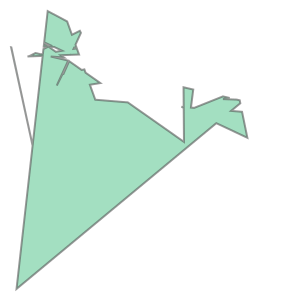

In [13]:
# import geopandas as gpd

# gdf = gpd.read_file('/home/jovyan/data/ignitions/Maria2019U0081_f5421b23173641e18b5d780c6d528798.shp')
# gdf['geometry'][0]

In [14]:
# fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=200)

# # plot_matrix(X_0_lst[0], ax)
# # plot_matrix(X_0_lst[1], ax, color='blue')
# plot_matrix(X_0_lst[0], ax, color='black')
# plot_matrix(X_0_lst[1], ax, color='black')
# plot_matrix(X_0_lst[2], ax, color='black')
# plot_matrix(X_0_lst[3], ax, color='black')
# plot_matrix(X_0_lst[4], ax, color='black')
# plot_matrix(X_0_lst[5], ax, color='black')
# plot_matrix(X_0_lst[6], ax, color='black')
# plot_geometry(usr.db.gdfignition.iloc[4]['geometry'], ax)
# plot_geometry(usr.db.gdfignition.iloc[5]['geometry'], ax)
# plot_geometry(usr.db.gdfignition.iloc[6]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[10]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[11]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[12]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[13]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[14]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[15]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[16]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[17]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[18]['geometry'], ax)
# # plot_geometry(usr.db.gdfignition.iloc[0]['geometry'], ax)

## Compare the predictions from the updated states, observations and using only the first simulation

### 1. Predict with the updated states

In [14]:
usr_combined = futils.User(fp)
igniteidx_lst = []
compareidx_lst = []
for i, X_0 in enumerate(X_0_lst):
    obrow = usr.db.gdfignition.iloc[i]
    comprow = usr.db.gdfignition.iloc[i+1]
    
    vertices = X_0.mean(axis=1)
    geom = Polygon(zip(vertices[::2],vertices[1::2])).buffer(0)
    
    dt = obrow['datetime']
    desc = obrow['description']
    objid = str(obrow['objectid']) + '_updated'
    ftype = obrow['filetype']
    
    ignitions = state_to_ignitions(X_0.mean(axis=1, keepdims=True), [objid], [dt], [desc], [ftype], usr_combined)
    igniteidx_lst.append(ignitions['igniteidx'][0])
    compareidx_lst.append(comprow.name)
    
    usr_combined.db.gdfignition = pd.concat([usr_combined.db.gdfignition, gpd.GeoDataFrame(ignitions, geometry='geometry', crs='EPSG:5070').set_index('igniteidx')])

Database interaction not yet implemented. Use pickle file for dataframes instead!


In [15]:
igniteidx_lst_observed = []
compareidx_lst_observed = []
for i in range(len(igniteidx_lst)):
    igniteidx_lst_observed.append(usr_combined.db.gdfignition.index[i])
    compareidx_lst_observed.append(usr_combined.db.gdfignition.index[i+1])

In [16]:
# Combine all igniteidx and compareidx into a single

igniteidx_lst_combined = igniteidx_lst + igniteidx_lst_observed
compareidx_lst_combined = compareidx_lst + compareidx_lst_observed

desc_lst_combined = ['Maria2019_updated' for i in range(len(igniteidx_lst))] + ['Maria2019_observed' for i in range(len(igniteidx_lst))]
inputData_lst = []
mainapi_lst = []
for (igniteidx, compareidx, desc) in zip(igniteidx_lst_combined, compareidx_lst_combined, desc_lst_combined):
    inputData = {'description': desc,
                 'igniteidx'  : igniteidx,
                 'compareidx' : compareidx,
                 'lcpidx'     : '43b7f5db36994599861eec4849cc68fd',
                 'barrieridx' : 'cb47616cd2dc4ccc8fd523bd3a5064bb',
                 
                 'windspeed': 10, 'winddirection': 90,
                 'relhumid': 90, 'temperature': 20}
    
    mainapi_lst.append(usr_combined.calculatePerimeters(inputData))
    
for mainapi in mainapi_lst:
    # pool.apply_async(farsite.run_command, callback=farsite.updatedb)
    mainapi.run_farsite()

{'description': 'Maria2019_updated', 'igniteidx': 'baeb29c2da8844d2abbbccfe5e3ce349', 'compareidx': '9f82e870591748a9a8a01346d174f2a1', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019_updated', 'igniteidx': '7cc10787fae849489d4b84a126b34024', 'compareidx': '1a6eb30ee33742e18fa6bb26678b5077', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosing a perimeter from the database
{'description': 'Maria2019_updated', 'igniteidx': '9c0902fde8054050b4ca029ab0acf56a', 'compareidx': '911f9b001c054b74a6ba70958f5f3c93', 'lcpidx': '43b7f5db36994599861eec4849cc68fd', 'barrieridx': 'cb47616cd2dc4ccc8fd523bd3a5064bb', 'windspeed': 10, 'winddirection': 90, 'relhumid': 90, 'temperature': 20}
Choosin

/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00910/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0000_7cc10787fae849489d4b84a126b34024.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00910/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00911/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0000_9c0902fde8054050b4ca029ab0acf56a.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00911/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00912/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0000_b50458e45a5d4c5488ad273374b5b341.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00912/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00913/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0000_531707888cde434b9f2f57bbba00dd74.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00913/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00914/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0000_782715ccc49344fb93d975e48a6d267e.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00914/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00915/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0000_ddb9af6c0a1b4cf28494af7f2284c640.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00915/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00916/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0000_0c1c78200dcc4a3a9ab4d3d92d0097ef.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00916/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00917/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0000_10a0a41edda2498ea4e2ed55a689ec64.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00917/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00918/config
Loading ignition file for Farsite #1: /home/jovyan/data/ignitions/Maria2019U0000_3303ab6746da4b4481b89a892f7bacd9.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 7)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00918/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00919/config
Loading ignition file for Farsite #1: /home/jovyan/farsite/inputs/maria_ignite/maria_21231.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 12)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00919/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00920/config
Loading ignition file for Farsite #1: /home/jovyan/farsite/inputs/maria_ignite/maria_21232.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 19)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00920/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00921/config
Loading ignition file for Farsite #1: /home/jovyan/farsite/inputs/maria_ignite/maria_21234.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00921/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00922/config
Loading ignition file for Farsite #1: /home/jovyan/farsite/inputs/maria_ignite/maria_21235.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00922/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00923/config
Loading ignition file for Farsite #1: /home/jovyan/farsite/inputs/maria_ignite/maria_21236.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 124)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00923/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00924/config
Loading ignition file for Farsite #1: /home/jovyan/farsite/inputs/maria_ignite/maria_21237.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00924/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00925/config
Loading ignition file for Farsite #1: /home/jovyan/farsite/inputs/maria_ignite/maria_21238.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 24)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00925/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00926/config
Loading ignition file for Farsite #1: /home/jovyan/farsite/inputs/maria_ignite/maria_21239.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 15)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00926/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00927/config
Loading ignition file for Farsite #1: /home/jovyan/farsite/inputs/maria_ignite/maria_21240.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 10)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00927/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


Farsite $Rev: 2395 $
Number of parallel threads = 4 (omp_get_num_procs = 128).
Loading lcp file for Farsite #1: /home/jovyan/farsite/inputs/landscapes/Maria2019.lcp
Loading inputs file for Farsite #1: /home/jovyan/data/20230120/Run_00928/config
Loading ignition file for Farsite #1: /home/jovyan/farsite/inputs/maria_ignite/maria_21241.shp
Loading barrier file for Farsite #1: /home/jovyan/farsite/inputs/barriers/NoBarrier/NoBarrier.shp
Launching Farsite #1
Starting time step 0.000000 (maximum = 7)
Writing outputs for Farsite #1 to /home/jovyan/data/20230120/Run_00928/out


/home/jovyan/farsite-devAPI/src/farsiteutils_v2.py:177: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.gdfsimulation = self.gdfsimulation.append(gdfappend)


In [17]:
# usr_combined.db.gdfignition.to_pickle('/home/jovyan/ignitions.pkl')
# usr_combined.db.gdfsimulation.to_pickle('/home/jovyan/simulations.pkl')

#### Interpolate all the vertices

#### TODO: Vertices include an additional point when generated from geometry. Remove the repeat!

#### TODO: Check whether the aligned_vertices have the correct roll amount
1. Create matrices from the aligned_vertices, and form the $X_0$ ensemble state matrix
2. Using the observation $y_1$, update the state vector and obtain $X_1$

#### TODO - Question: Can we find a way to not interpolate the vertices
1. Without interpolation, we need to create a matrix that maps the observed vertices to the state vector

## Compare the perimeters

In [18]:
# gdfignition = pd.read_pickle('/home/jovyan/ignitions.pkl')
# gdfsimulation = pd.read_pickle('/home/jovyan/simulations.pkl')

gdfignition = usr_combined.db.gdfignition
gdfsimulation = usr_combined.db.gdfsimulation

gdfignition_model = usr_model.db.gdfignition
gdfsimulation_model = usr_model.db.gdfsimulation

In [24]:
def get_coordinates(geom):
    x,y = geom.exterior.coords.xy
    x = np.array(x)
    y = np.array(y)
    
    return x,y

def calculate_rms(geom1, geom2):
    xy1, xy2 = interpolate_geometries([geom1, geom2], vertex_count=2000)
    xy1, xy2 = align_vertices([xy1, xy2])
    return np.sqrt(np.sum((xy1[:,0] - xy2[:,0])**2 + (xy1[:,1] - xy2[:,1])**2)/xy1.shape[0])
    

def calculate_area_diff(geom1, geom2):
    return (geom1.union(geom2) - geom1.intersection(geom2)).area

calculate_error = calculate_rms

In [25]:
geoms_updated = []
geoms_observed = []
geoms_compare = []
geoms_model = []
errors_updated = []
errors_observed = []
errors_model = []
dt = []

for compareidx in compareidx_lst[:-1]:
    gdffiltered = gdfsimulation[gdfsimulation['compareidx'] == compareidx]
    
    geom_updated = gdffiltered[gdffiltered['description'] == 'Maria2019_updated']['geometry'].iloc[0]
    if isinstance(geom_updated, MultiPolygon):
        geom_updated = calculate_max_area_geom(geom_updated)
    geoms_updated.append(geom_updated)
    
    geom_observed = gdffiltered[gdffiltered['description'] == 'Maria2019_observed']['geometry'].iloc[0]
    if isinstance(geom_observed, MultiPolygon):
        geom_observed = calculate_max_area_geom(geom_observed)
    geoms_observed.append(geom_observed)
    
    geom_compare = gdfignition.loc[compareidx, 'geometry']
    if isinstance(geom_compare, MultiPolygon):
        geom_compare = calculate_max_area_geom(geom_compare)
    geoms_compare.append(geom_compare)
    
    gdffiltered_model = gdfsimulation_model[gdfsimulation_model['compareidx'] == compareidx]
    geom_model = gdffiltered_model[gdffiltered_model['description'] == 'Maria2019']['geometry'].iloc[0]
    if isinstance(geom_model, MultiPolygon):
            geom_model = calculate_max_area_geom(geom_model)
    geoms_model.append(geom_model)
    
    dt.append((gdfignition.loc[compareidx, 'datetime'] - gdfignition.iloc[0]['datetime']).total_seconds()/60/60)
    
    errors_updated.append(calculate_error(geom_updated, geom_compare))
    errors_observed.append(calculate_error(geom_observed,  geom_compare))
    errors_model.append(calculate_error(geom_model, geom_compare))

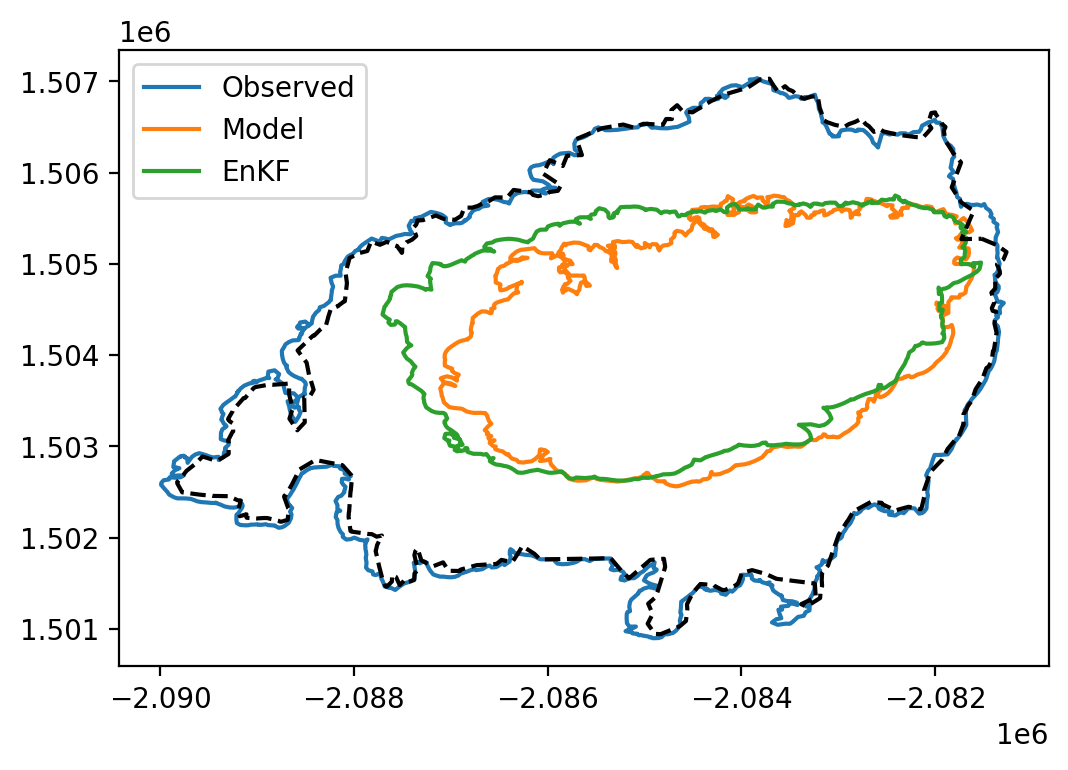

In [52]:
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=200)

i = 5
plot_geometry(geoms_observed[i], ax=ax, label='Observed')
plot_geometry(geoms_model[i], ax=ax, label='Model')
plot_geometry(geoms_updated[i], ax=ax, label='EnKF')
plot_geometry(geoms_compare[i], ax=ax, ls='--', color='black')

ax.legend()

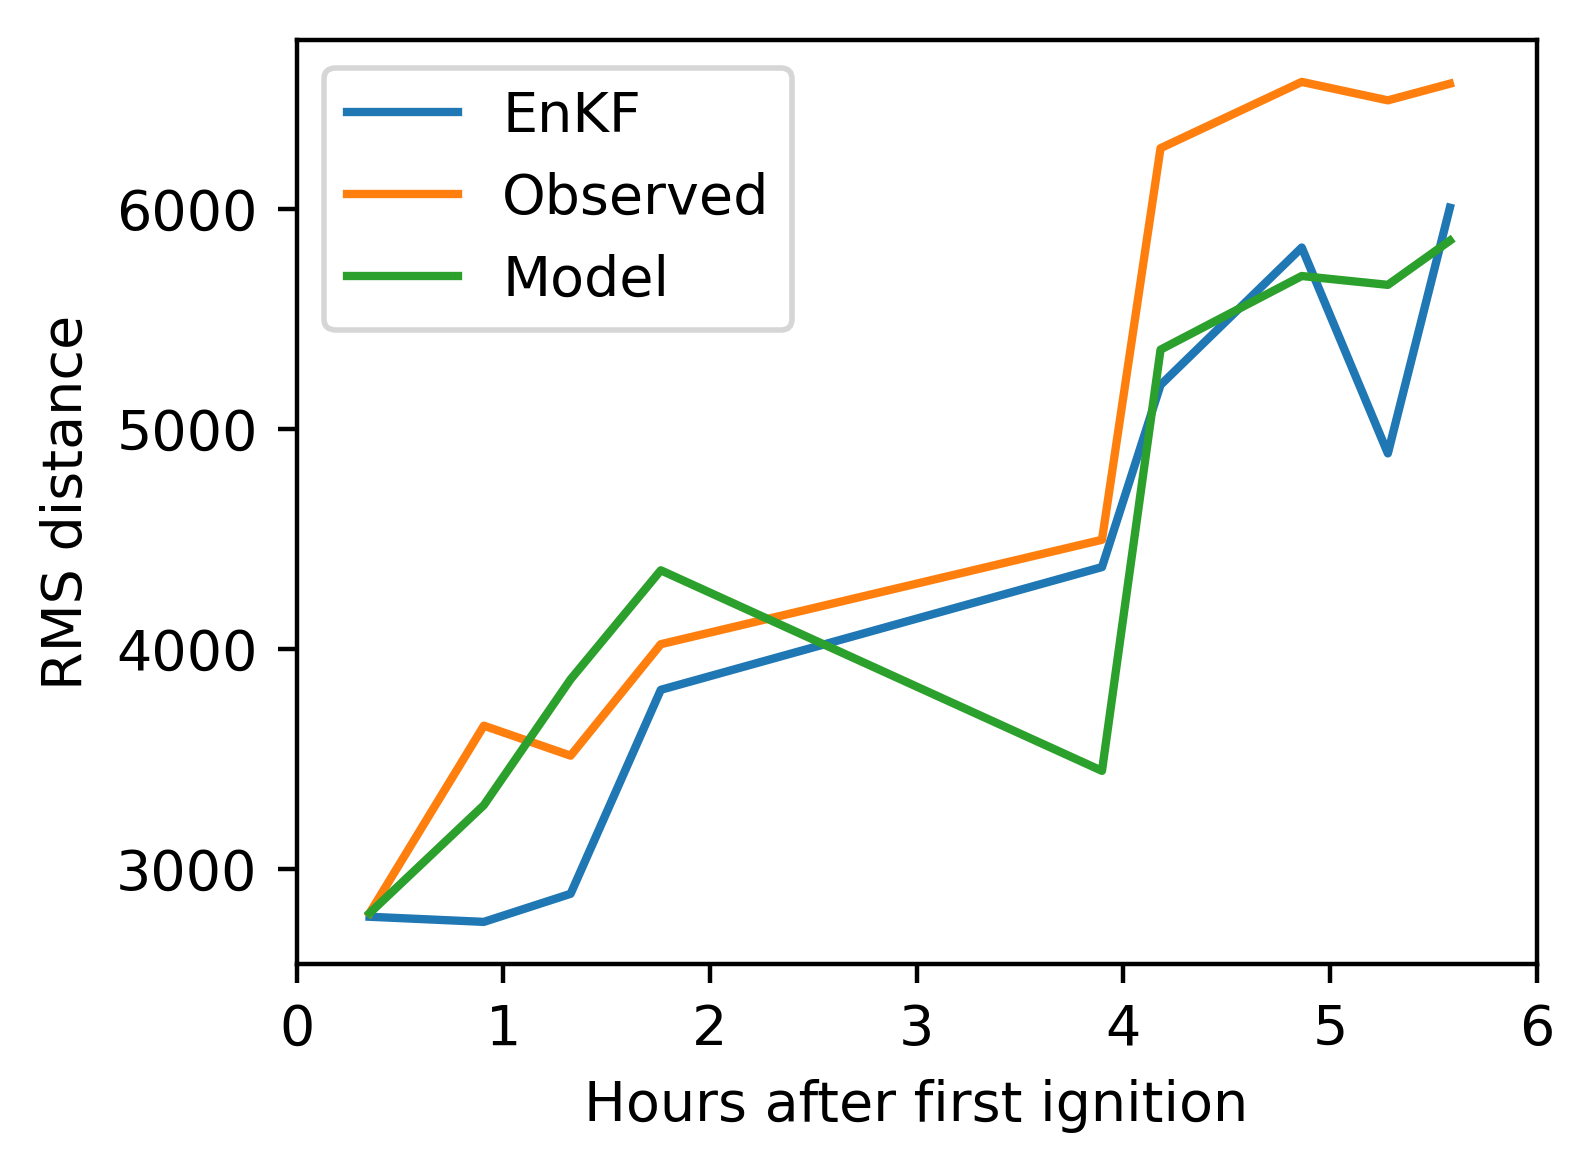

In [28]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=400)
ax.plot(dt, errors_updated, label='EnKF')
ax.plot(dt, errors_observed, label='Observed')
ax.plot(dt, errors_model, label='Model')

ax.set_xlim(0,6)
# ax.set_ylim(0, 2.5e7)

ax.set_xlabel('Hours after first ignition')
ax.set_ylabel('RMS distance')

ax.legend()